In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr
from os import path
from mmctools.wrf.utils import tsout_seriesReader, Tower
import glob
import numpy as np
from string import ascii_lowercase

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# - - - - USER SETTINGS - - - - #
# don't forget the trailing slash!
main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/' 
# - - - END USER SETTINGS - - - #
from NYSERDA_case_dict import case_dict
cases = [case_dict[x]['case_str'] for x in list(case_dict.keys())]

# # # FOR TESTING # # #
#cases = [cases[0]] + cases[3:6]#  + [cases[-1]]
cases = cases[:]
for cc,case in enumerate(cases): print(cc,case)
# # # # # # # # # # # #

dom_dict = {1: {'dt':15,
                'marker': r'$ 1 $',
                'ls':'-'},
            2: {'dt':5,
                'marker': r'$ 2 $',
                'ls':'--'},
            3: {'dt':1,
                'marker': r'$ 3 $',
                'ls':'-'},
            4: {'dt':0.2,
                'marker': r'$ 4 $',
                'ls':'-.'},
            5: {'dt':0.04,
                'marker': r'$ 5 $',
                'ls':':'},
            }
doms_of_interest = [1,2,3,4,5]

0 MERRA2_DFLT_NOSK_CHRN_MDIS
1 MERRA2_CMCS_NOSK_CHRN_MDIS
2 MERRA2_OSPO_NOSK_CHRN_MDIS
3 MERRA2_MURS_NOSK_CHRN_MDIS
4 MERRA2_NAVO_NOSK_CHRN_MDIS
5 MERRA2_OSTI_NOSK_CHRN_MDIS
6 MERRA2_GO16_NOSK_CHRN_MDIS
7 MERRA2_DFLT_NOSK_SHAL_MDIS


In [4]:
def averageTslistData(data):
    avg_twr = data.mean(dim='station')
    avg_twr['lon'] = data.lon.mean(dim='station')
    avg_twr['lat'] = data.lat.mean(dim='station')
    avg_twr['zsurface'] = data.zsurface.mean(dim='station')

    avg_twr = avg_twr.assign_coords({'station':'E06',
                                     'lat':avg_twr.lat,
                                     'lon':avg_twr.lon,
                                     'zsurface':avg_twr.zsurface}).expand_dims({'station':1})
    return(avg_twr)

In [5]:
for dd,dom in enumerate(doms_of_interest[-1:]):
    
    time_step = dom_dict[dom]['dt']
    dom_str = 'd0{}'.format(dom)

    for cc,case in enumerate(cases[:1]):
        tower_f = '{0}tower_netCDFs/NYSERDA_{1}_towers_{2}test.nc'.format(main_directory,case,dom_str)
        avg_tower_f = tower_f.replace('.nc','_avg.nc') 

        sim_start = '2020-04-04 06:00:00'
        
        if dom >= 3:
            #restarts = sorted(glob.glob('{}{}/RESTART_*'.format(main_directory,case)))[:]
            restarts = sorted(glob.glob('{}{}/old_RESTARTS/RESTART_*'.format(main_directory,case)))[:]
            restarts = [rst.split('/')[-1] for rst in restarts]
            # Get rid of duplicate restart directories... the last one is always good:
            dup_restarts = []
            for rst in restarts:
                if len(rst) > len('RESTART_X'):
                    dup_restarts += [rst]
            head_restarts = []
            for rst in dup_restarts:
                head_rst = rst[:-2]
                if head_rst not in head_restarts:
                    head_restarts += [head_rst]
            for head_rst in head_restarts:
                dup_rsts = []
                for dup_rst in dup_restarts:
                    if head_rst in dup_rst: dup_rsts += [dup_rst]
                dup_rsts = [head_rst] + dup_rsts
                dup_rsts = sorted(dup_rsts)
                keep_rst = dup_rsts[-1]
                dup_rsts = dup_rsts[:-1]
                add_ind = restarts.index(dup_rsts[0])
                for rst in dup_rsts:
                    restarts.remove(rst)
                restarts = restarts[:add_ind] + [keep_rst] + restarts[add_ind+1:]
            f_dir = '{}{}/'.format(main_directory,case)
            get_avg_profile = True
        else:
            restarts = ['RESTART_A']
            f_dir = '{}{}/'.format(main_directory,case)
            get_avg_profile = False

        if path.exists(tower_f):
            tower_dat = xr.open_dataset(tower_f)

        else:
            print('Reading tslist output...')
            if dom in [1,2]:
                select_vars = ['tk','u','v','w','height','lat','lon','i','j','zsurface']
                select_towers = ['E06']
            else:
                select_vars = ['tk','u','v','w','ph','lat','lon','i','j','zsurface']

                tower_files = sorted(glob.glob('{}old_RESTARTS/{}/*.d0?.??'.format(f_dir,restarts[-1])))
                towers = []
                for twrf in tower_files:
                    towers += [twrf.split('/')[-1].split('.')[0]]
                towers = np.unique(towers)
                
                # Only towers:
                #select_towers = [twr for twr in towers if twr[0] == 'T']
                select_towers = towers[:]

            restarts = restarts[-2:]
            tower_dat = tsout_seriesReader(fdir=f_dir+'old_RESTARTS/',
                                           restarts=restarts,
                                           simulation_start_time=[sim_start]*len(restarts),
                                           domain_of_interest=dom_str,
                                           time_step=time_step,
                                           structure='unordered',
                                           select_tower=select_towers,
                                           select_vars=select_vars,
                                          )
            
            
            '''
            tower_dat = tsout_seriesReader(fdir=f_dir,
                                           restarts=restarts,
                                           simulation_start_time=[sim_start]*len(restarts),
                                           domain_of_interest=dom_str,
                                           time_step=time_step,
                                           structure='unordered',
                                           select_tower=select_towers,
                                           #heights=[ 18.,  38.,  58.,  78.,  98., 118., 138., 158., 178., 198.],
                                           #height_var='ph',
                                           select_vars=select_vars,
                                          )
            '''
            print(tower_dat)
            wefwef
            tower_dat.to_netcdf(tower_f.replace('.nc','temp.nc'))
            

Reading tslist output...
restart: RESTART_U
starting E06.d05
starting T001.d05
starting T002.d05
starting T003.d05
starting T004.d05
starting T005.d05
starting T006.d05
starting T007.d05
starting T008.d05
starting T009.d05
starting T010.d05
starting T011.d05
starting T012.d05
starting T013.d05
starting T014.d05
starting T015.d05
starting T016.d05
starting T017.d05
starting T018.d05
starting T019.d05
starting T020.d05
starting T021.d05
starting T022.d05
starting T023.d05
starting T024.d05
starting T025.d05
starting T026.d05
starting T027.d05
starting T028.d05
starting T029.d05
starting T030.d05
starting T031.d05
starting T032.d05
starting T033.d05
starting T034.d05
starting T035.d05
starting T036.d05
starting T037.d05
starting T038.d05
starting T039.d05
starting T040.d05
starting T041.d05
starting T042.d05
starting T043.d05
starting T044.d05
starting T045.d05
starting T046.d05
starting T047.d05
starting T048.d05
starting T049.d05
starting T050.d05
starting T051.d05
starting T052.d05
sta

KeyboardInterrupt: 

In [ ]:
for dd,dom in enumerate(doms_of_interest[4:]):
    
    time_step = dom_dict[dom]['dt']
    dom_str = 'd0{}'.format(dom)

    for cc,case in enumerate(cases):
        tower_f = '{0}tower_netCDFs/NYSERDA_{1}_towers_{2}test.nc'.format(main_directory,case,dom_str)
        avg_tower_f = tower_f.replace('.nc','_avg.nc') 

        sim_start = '2020-04-04 06:00:00'
        
        if dom >= 3:
            restarts = sorted(glob.glob('{}{}/old_RESTARTS/RESTART_*'.format(main_directory,case)))[3:]

            restarts = [rst.split('/')[-1] for rst in restarts]
            # Get rid of duplicate restart directories... the last one is always good:
            dup_restarts = []
            for rst in restarts:
                if len(rst) > len('RESTART_X'):
                    dup_restarts += [rst]
            head_restarts = []
            for rst in dup_restarts:
                head_rst = rst[:-2]
                if head_rst not in head_restarts:
                    head_restarts += [head_rst]
            for head_rst in head_restarts:
                dup_rsts = []
                for dup_rst in dup_restarts:
                    if head_rst in dup_rst: dup_rsts += [dup_rst]
                dup_rsts = [head_rst] + dup_rsts
                dup_rsts = sorted(dup_rsts)
                keep_rst = dup_rsts[-1]
                dup_rsts = dup_rsts[:-1]
                add_ind = restarts.index(dup_rsts[0])
                for rst in dup_rsts:
                    restarts.remove(rst)
                restarts = restarts[:add_ind] + [keep_rst] + restarts[add_ind+1:]

            f_dir = '{}{}/'.format(main_directory,case)
            get_avg_profile = True
        else:
            restarts = ['RESTART_A']
            f_dir = '{}{}/'.format(main_directory,case)
            get_avg_profile = False

        if path.exists(tower_f):
            tower_dat = xr.open_dataset(tower_f)

        else:
            print('Reading tslist output...')

            if dom in [1,2]:
                select_vars = ['tk','u','v','w','height','lat','lon','i','j','zsurface']
                select_towers = ['E06']
            else:
                select_vars = ['tk','u','v','w','ph','lat','lon','i','j','zsurface']

                tower_files = sorted(glob.glob('{}old_RESTARTS/{}/*.d0?.??'.format(f_dir,restarts[0])))
                towers = []
                for twrf in tower_files:
                    towers += [twrf.split('/')[-1].split('.')[0]]
                towers = np.unique(towers)
                
                # Only towers:
                #select_towers = [twr for twr in towers if twr[0] == 'T']
                select_towers = towers[:]

                
            restarts = restarts[-2:]

            tower_dat = tsout_seriesReader(fdir=f_dir+'old_RESTARTS/',
                                           restarts=restarts,
                                           simulation_start_time=[sim_start]*len(restarts),
                                           domain_of_interest=dom_str,
                                           time_step=time_step,
                                           structure='unordered',
                                           select_tower=select_towers,
                                           select_vars=select_vars,
                                          )
            
            
            '''
            tower_dat = tsout_seriesReader(fdir=f_dir,
                                           restarts=restarts,
                                           simulation_start_time=[sim_start]*len(restarts),
                                           domain_of_interest=dom_str,
                                           time_step=time_step,
                                           structure='unordered',
                                           select_tower=select_towers,
                                           #heights=[ 18.,  38.,  58.,  78.,  98., 118., 138., 158., 178., 198.],
                                           #height_var='ph',
                                           select_vars=select_vars,
                                          )
            '''
            print(tower_dat)
            wefwef
            tower_dat.to_netcdf(tower_f.replace('.nc','temp.nc'))
            

In [ ]:
e06_dict = {}

for dd,dom in enumerate(doms_of_interest):
    
    time_step = dom_dict[dom]['dt']
    dom_str = 'd0{}'.format(dom)

    case = cases[0]
    tower_f = '{0}tower_netCDFs/NYSERDA_{1}_towers_{2}test.nc'.format(main_directory,case,dom_str)
    avg_tower_f = tower_f.replace('.nc','_avg.nc') 

    sim_start = '2020-04-04 06:00:00'

    restarts = sorted(glob.glob('{}{}/RESTART_*'.format(main_directory,case)))[3:]

    restarts = [rst.split('/')[-1] for rst in restarts]
    # Get rid of duplicate restart directories... the last one is always good:
    dup_restarts = []
    for rst in restarts:
        if len(rst) > len('RESTART_X'):
            dup_restarts += [rst]
    head_restarts = []
    for rst in dup_restarts:
        head_rst = rst[:-2]
        if head_rst not in head_restarts:
            head_restarts += [head_rst]
    for head_rst in head_restarts:
        dup_rsts = []
        for dup_rst in dup_restarts:
            if head_rst in dup_rst: dup_rsts += [dup_rst]
        dup_rsts = [head_rst] + dup_rsts
        dup_rsts = sorted(dup_rsts)
        keep_rst = dup_rsts[-1]
        dup_rsts = dup_rsts[:-1]
        add_ind = restarts.index(dup_rsts[0])
        for rst in dup_rsts:
            restarts.remove(rst)
        restarts = restarts[:add_ind] + [keep_rst] + restarts[add_ind+1:]

    f_dir = '{}{}/'.format(main_directory,case)


    if dom in [1,2]:
        select_vars = ['tk','u','v','w','ph','lat','lon','i','j','zsurface','u10','v10','tsk','theta']
        select_towers = ['E06']
    else:
        select_vars = ['tk','u','v','w','ph','lat','lon','i','j','zsurface','u10','v10','tsk','theta']

        tower_files = sorted(glob.glob('{}{}/*.d0?.??'.format(f_dir,restarts[0])))
        towers = []
        for twrf in tower_files:
            towers += [twrf.split('/')[-1].split('.')[0]]
        towers = np.unique(towers)

        # Only towers:
        #select_towers = [twr for twr in towers if twr[0] == 'T']
        select_towers = towers[:9]


    restarts = restarts[-3:]

    e06_dict[dom] = tsout_seriesReader(fdir=f_dir,
                                   restarts=restarts,
                                   simulation_start_time=[sim_start]*len(restarts),
                                   domain_of_interest=dom_str,
                                   time_step=time_step,
                                   structure='unordered',
                                   select_tower=select_towers,
                                   select_vars=select_vars,
                                  )


In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=5,figsize=(14,24))
plt.subplots_adjust(hspace=0.4)
for dd,dom in enumerate([1,2,3,4,5]):
    wrfin = xr.open_dataset('{}{}/wrfinput_d0{}'.format(main_directory,cases[0],dom)).squeeze()
    ca = ax[dd,0].pcolormesh(wrfin.XLONG,wrfin.XLAT,wrfin.COSALPHA)
    sa = ax[dd,1].pcolormesh(wrfin.XLONG,wrfin.XLAT,wrfin.SINALPHA)
    for axi in range(0,2):
        ax[dd,axi].tick_params(labelsize=14)


    plt.colorbar(ca,ax=ax[dd,0])
    plt.colorbar(sa,ax=ax[dd,1])
    ax[dd,0].text(0.01,1.01,'Domain-{}'.format(dom),
                  size=22,transform=ax[dd,0].transAxes,
                  va='bottom')
ax[0,0].set_title('COSALPHA',size=18,y=1.2)
ax[0,1].set_title('SINALPHA',size=18,y=1.2)
ax[-1,0].set_xlabel('Longitude',size=16)
ax[-1,1].set_xlabel('Longitude',size=16)
ax[-1,0].set_ylabel('Latitude',size=16)
plt.show()

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(14,6))
ca = ax[0].pcolormesh(wrfin.XLONG,wrfin.XLAT,cosalpha)
sa = ax[1].pcolormesh(wrfin.XLONG,wrfin.XLAT,sinalpha)
for axi in range(0,2):
    ax[axi].tick_params(labelsize=14)
    ax[axi].set_xlabel('Longitude',size=16)
ax[0].set_ylabel('Latitude',size=16)
ax[0].set_title('COSALPHA',size=20)
ax[1].set_title('SINALPHA',size=20)

plt.colorbar(ca,ax=ax[0])
plt.colorbar(sa,ax=ax[1])
plt.show()

In [ ]:
wrfout_dict = {}

wrf_vars = ['U','V']

rotate = False
rotate_match_wrf = True

for dd,dom in enumerate([5]):
    print('Starting d0{}'.format(dom))
    wrfout_f = sorted(glob.glob('{}{}/wrfout_d0{}*'.format(main_directory,case,dom)))[6:]

    wrfin = xr.open_dataset('{}{}/wrfinput_d0{}'.format(main_directory,cases[0],dom)).squeeze()
    cosalpha = wrfin.COSALPHA
    sinalpha = wrfin.SINALPHA

    init_wrf_f = True
    print('getting wrfouts')
    for wf in wrfout_f[-13:]:
        wrf = xr.open_dataset(wf,decode_times=False).sel(Time=0)
        wrf_time = pd.to_datetime(' '.join(wf.split('/')[-1].split('_')[-2:]))
        wrf = wrf[wrf_vars]
        wrf = wrf.expand_dims({'datetime':[wrf_time]})
        wrf = wrf.drop('XTIME')

        if init_wrf_f:
            wrf_f = wrf.copy()
            init_wrf_f = False
        else:
            wrf_f = xr.merge([wrf_f,wrf])

    if rotate:
        print('destaggering')
        if not rotate_match_wrf:
            wrf_u = (wrf_f.U[:,:,:,1:] + wrf_f.U[:,:,:,:-1])*0.5
            wrf_v = (wrf_f.V[:,:,1:,:] + wrf_f.V[:,:,:-1,:])*0.5
            wrf_u = wrf_u.rename({'west_east_stag':'west_east'})
            wrf_v = wrf_v.rename({'south_north_stag':'south_north'})
            ue = wrf_u * cosalpha - wrf_v * sinalpha
            ve = wrf_v * cosalpha + wrf_u * sinalpha
        else:
            print('rotating and destaggering')
            '''
             440  earth_u_profile(k) = &
             441      ((grid%u_2(ix,k,iy)*grid%cosa(ix,iy)-grid%v_2(ix,k,iy)*grid%sina(ix,iy)) + &
             442      (grid%u_2(ix+1,k,iy)*grid%cosa(ix+1,iy)-grid%v_2(ix+1,k,iy)*grid%sina(ix+1,iy)))/2.0
             443  earth_v_profile(k) = &
             444      ((grid%v_2(ix,k,iy)*grid%cosa(ix,iy)+grid%u_2(ix,k,iy)*grid%sina(ix,iy)) + &
             445      (grid%v_2(ix,k,iy+1)*grid%cosa(ix,iy+1)+grid%u_2(ix,k,iy+1)*grid%sina(ix,iy+1)))/2.0
            '''
            wrf_uA = wrf_f.U[:,:,:,:-1]
            wrf_vA = wrf_f.V[:,:,:-1,:]

            wrf_uB = wrf_f.U[:,:,:,1:]
            wrf_vB = wrf_f.V[:,:,1:,:]

            wrf_uA = wrf_uA.rename({'west_east_stag':'west_east'})
            wrf_uB = wrf_uB.rename({'west_east_stag':'west_east'})

            wrf_vA = wrf_vA.rename({'south_north_stag':'south_north'})
            wrf_vB = wrf_vB.rename({'south_north_stag':'south_north'})


            ue = ((wrf_uA*cosalpha - wrf_vA*sinalpha) + \
                    (wrf_uB*cosalpha - wrf_vB*sinalpha))/2.0
            ve = ((wrf_vA*cosalpha + wrf_vA*sinalpha) + \
                    (wrf_vB*cosalpha + wrf_uB*sinalpha))/2.0
    else:
        wrf_u = (wrf_f.U[:,:,:,1:] + wrf_f.U[:,:,:,:-1])*0.5
        wrf_v = (wrf_f.V[:,:,1:,:] + wrf_f.V[:,:,:-1,:])*0.5
        wrf_u = wrf_u.rename({'west_east_stag':'west_east'})
        wrf_v = wrf_v.rename({'south_north_stag':'south_north'})
        ue = wrf_u
        ve = wrf_v

    wrf_f.drop(['U','V'])

    wrf_f['U'] = ue
    wrf_f['V'] = ve

    wrf_f = wrf_f.drop(['XLAT_U','XLAT_V','XLONG_U','XLONG_V'])
    wrfout_dict[dom] = wrf_f
    wrf_d05 = wrf_f

In [ ]:
#wrfout_dict = {}

wrf_vars = ['U','V']

rotate = False
rotate_match_wrf = True

for dd,dom in enumerate([5]):
    print('Starting d0{}'.format(dom))
    wrfout_f = sorted(glob.glob('{}{}/wrfout_d0{}*'.format(main_directory,case,dom)))[6:]

    wrfin = xr.open_dataset('{}{}/wrfinput_d0{}'.format(main_directory,cases[0],dom)).squeeze()
    cosalpha = wrfin.COSALPHA
    sinalpha = wrfin.SINALPHA

    init_wrf_f = True
    print('getting wrfouts')
    for wf in wrfout_f[-13:]:
        wrf = xr.open_dataset(wf,decode_times=False).sel(Time=0)
        wrf_time = pd.to_datetime(' '.join(wf.split('/')[-1].split('_')[-2:]))
        wrf = wrf[wrf_vars]
        wrf = wrf.expand_dims({'datetime':[wrf_time]})
        wrf = wrf.drop('XTIME')

        if init_wrf_f:
            wrf_f = wrf.copy()
            init_wrf_f = False
        else:
            wrf_f = xr.merge([wrf_f,wrf])

    if rotate:
        print('destaggering')
        if not rotate_match_wrf:
            wrf_u = (wrf_f.U[:,:,:,1:] + wrf_f.U[:,:,:,:-1])*0.5
            wrf_v = (wrf_f.V[:,:,1:,:] + wrf_f.V[:,:,:-1,:])*0.5
            wrf_u = wrf_u.rename({'west_east_stag':'west_east'})
            wrf_v = wrf_v.rename({'south_north_stag':'south_north'})
            ue = wrf_u * cosalpha - wrf_v * sinalpha
            ve = wrf_v * cosalpha + wrf_u * sinalpha
        else:
            print('rotating and destaggering')
            '''
             440  earth_u_profile(k) = &
             441      ((grid%u_2(ix,k,iy)*grid%cosa(ix,iy)-grid%v_2(ix,k,iy)*grid%sina(ix,iy)) + &
             442      (grid%u_2(ix+1,k,iy)*grid%cosa(ix+1,iy)-grid%v_2(ix+1,k,iy)*grid%sina(ix+1,iy)))/2.0
             443  earth_v_profile(k) = &
             444      ((grid%v_2(ix,k,iy)*grid%cosa(ix,iy)+grid%u_2(ix,k,iy)*grid%sina(ix,iy)) + &
             445      (grid%v_2(ix,k,iy+1)*grid%cosa(ix,iy+1)+grid%u_2(ix,k,iy+1)*grid%sina(ix,iy+1)))/2.0
            '''
            wrf_uA = wrf_f.U[:,:,:,:-1]
            wrf_vA = wrf_f.V[:,:,:-1,:]

            wrf_uB = wrf_f.U[:,:,:,1:]
            wrf_vB = wrf_f.V[:,:,1:,:]

            wrf_uA = wrf_uA.rename({'west_east_stag':'west_east'})
            wrf_uB = wrf_uB.rename({'west_east_stag':'west_east'})

            wrf_vA = wrf_vA.rename({'south_north_stag':'south_north'})
            wrf_vB = wrf_vB.rename({'south_north_stag':'south_north'})


            ue = ((wrf_uA*cosalpha - wrf_vA*sinalpha) + \
                    (wrf_uB*cosalpha - wrf_vB*sinalpha))/2.0
            ve = ((wrf_vA*cosalpha + wrf_vA*sinalpha) + \
                    (wrf_vB*cosalpha + wrf_uB*sinalpha))/2.0
    else:
        wrf_u = (wrf_f.U[:,:,:,1:] + wrf_f.U[:,:,:,:-1])*0.5
        wrf_v = (wrf_f.V[:,:,1:,:] + wrf_f.V[:,:,:-1,:])*0.5
        wrf_u = wrf_u.rename({'west_east_stag':'west_east'})
        wrf_v = wrf_v.rename({'south_north_stag':'south_north'})
        ue = wrf_u
        ve = wrf_v

    wrf_f.drop(['U','V'])

    wrf_f['U'] = ue
    wrf_f['V'] = ve

    wrf_f = wrf_f.drop(['XLAT_U','XLAT_V','XLONG_U','XLONG_V'])
    #wrfout_dict[dom] = wrf_f
    wrf_d05 = wrf_f

In [ ]:
wrf_d05.U.isel(datetime=-1,bottom_top=10).plot()

In [ ]:
dom = 5
varn = 'U'
fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
for stn in tower_dat.station[:]:
    twr = tower_dat.sel(station=stn,nz=0)
    wrf_u = wrfout_dict[dom][varn].copy()
    c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)
    #twr.u.plot(ax=ax[0])
    #twr.u.plot(ax=ax[1],c='grey',alpha=0.05)
    c.plot(ax=ax[1],marker='o')
ax[0].set_title('tslist Output',size=16)
ax[1].set_title('WRF Output at tslist Locations',size=16)
for axi in range(0,2):
    ax[axi].tick_params(labelsize=14)
    ax[axi].set_xlabel('Datetime',size=16)
ax[0].set_ylabel('U',size=16)
ax[1].set_ylabel('',size=16)
plt.show()


In [ ]:
dom = 5
varn = 'U'
fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
for stn in tower_dat.station[:]:
    twr = tower_dat.sel(station=stn,nz=0)
    wrf_u = wrfout_dict[dom][varn].copy()
    c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)
    twr.u.plot(ax=ax[0])
    twr.u.plot(ax=ax[1],c='grey',alpha=0.05)
    c.plot(ax=ax[1],marker='o')
ax[0].set_title('tslist Output',size=16)
ax[1].set_title('WRF Output at tslist Locations',size=16)
for axi in range(0,2):
    ax[axi].tick_params(labelsize=14)
    ax[axi].set_xlabel('Datetime',size=16)
ax[0].set_ylabel('U',size=16)
ax[1].set_ylabel('',size=16)
plt.show()


In [ ]:
dom = 5
kk = 30

for varn in ['U','V']:
    fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
    for stn in tower_dat.station[:]:
        twr = tower_dat.sel(station=stn,nz=kk)
        wrf_u = wrfout_dict[dom][varn].copy()
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=kk)
        twr_plt, = twr[varn.lower()].plot(ax=ax[0])
        twr[varn.lower()].plot(ax=ax[1],alpha=0.5,c=twr_plt.get_color())
        c.plot(ax=ax[1],marker='o')
        c.plot(ax=ax[0],marker='x',lw=0.0,c=twr_plt.get_color(),alpha=0.8)
    ax[0].set_title('tslist Output',size=16)
    ax[1].set_title('WRF Output at tslist Locations',size=16)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=14)
        ax[axi].set_xlabel('Datetime',size=16)
    ax[0].set_ylabel(varn,size=16)
    ax[1].set_ylabel('',size=16)
    plt.show()


In [ ]:
dom = 3
kk = 30

for varn in ['U','V']:
    fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
    for stn in tower_dat.station[:]:
        twr = tower_dat.sel(station=stn,nz=kk)
        wrf_u = wrfout_dict[dom][varn].copy()
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=kk)
        twr_plt, = twr[varn.lower()].plot(ax=ax[0])
        twr[varn.lower()].plot(ax=ax[1],alpha=0.5,c=twr_plt.get_color())
        c.plot(ax=ax[1],marker='o')
        c.plot(ax=ax[0],marker='x',lw=0.0,c=twr_plt.get_color(),alpha=0.8)
    ax[0].set_title('tslist Output',size=16)
    ax[1].set_title('WRF Output at tslist Locations',size=16)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=14)
        ax[axi].set_xlabel('Datetime',size=16)
    ax[0].set_ylabel(varn,size=16)
    ax[1].set_ylabel('',size=16)
    plt.show()


In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
for ss,stn in enumerate(tower_dat.station[:]):
    twr = tower_dat.sel(station=stn)
    ue = twr.u.sel(nz=0)
    ve = twr.v.sel(nz=0)
    
    #sina = sinalpha.sel(west_east=twr.i-1,south_north=twr.j-1)
    #cosa = cosalpha.sel(west_east=twr.i-1,south_north=twr.j-1)
    #u = (ue + ve*(sina/cosa))/(cosa + (sina**2)/cosa)
    #v = (ve - u*sina)/(cosa)
    
    ue.plot(ax=ax[0])
    #u.plot(ax=ax[1])
    
for axi in range(0,2):
    ax[axi].tick_params(labelsize=14)
    ax[axi].set_xlabel('Datetime',size=16)
ax[0].set_ylabel('U',size=16)
ax[1].set_ylabel('',size=16)
ax[0].set_title('tslist orig',size=18)
ax[1].set_title('tslist un-rotated',size=18)
plt.show()
    #ve.plot()
    #v.plot()
    #plt.show()


In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
for ss,stn in enumerate(tower_dat.station[:]):
    twr = tower_dat.sel(station=stn)
    ue = twr.u.sel(nz=0)
    ve = twr.v.sel(nz=0)
    
    sina = sinalpha.sel(west_east=twr.i-1,south_north=twr.j-1)
    cosa = cosalpha.sel(west_east=twr.i-1,south_north=twr.j-1)
    u = (ue + ve*(sina/cosa))/(cosa + (sina**2)/cosa)
    v = (ve - u*sina)/(cosa)
    
    ve.plot(ax=ax[0])
    v.plot(ax=ax[1])
    
for axi in range(0,2):
    ax[axi].tick_params(labelsize=14)
    ax[axi].set_xlabel('Datetime',size=16)
ax[0].set_ylabel('V',size=16)
ax[1].set_ylabel('',size=16)
ax[0].set_title('tslist orig',size=18)
ax[1].set_title('tslist un-rotated',size=18)
plt.show()
    #ve.plot()
    #v.plot()
    #plt.show()


In [ ]:
for ff,ftime in enumerate(wrf_d05.datetime):
    ue = wrf_d05.sel(datetime=ftime,bottom_top=0).U
    ve = wrf_d05.sel(datetime=ftime,bottom_top=0).V
    
    u = (ue + ve*(sinalpha/cosalpha))/(cosalpha + (sinalpha**2)/cosalpha)
    #v = (ve - ue*(sinalpha/cosalpha))/(cosalpha + (sinalpha**2)/cosalpha)
    v = (ve - u*sinalpha)/(cosalpha)
    ue.plot()
    plt.show()
    u.plot()
    plt.show()
    
    ve.plot()
    plt.show()
    v.plot()
    plt.show()
    
    (v-ve).plot()
    plt.show()
    wefwef

In [ ]:
for wf in wrfout_f[6:]:
    wrf = xr.open_dataset(wf,decode_times=False).sel(Time=0)
    wrf_time = pd.to_datetime(' '.join(wf.split('/')[-1].split('_')[-2:]))
    v = wrf.V.sel(bottom_top=0)
    test = (v[1:,:] + v[:-1,:])*0.5
    test.plot()
    plt.show()
    wefwef

In [ ]:
xmin,xmax = tower_dat.lon.min()-0.001,tower_dat.lon.max()+0.001
ymin,ymax = tower_dat.lat.min()-0.001,tower_dat.lat.max()+0.001

for ff,ftime in enumerate(wrf_d05.datetime):
    fig,ax = plt.subplots(ncols=2,figsize=(14,6))
    u = wrf_d05.sel(datetime=ftime,bottom_top=0).U
    cplt = ax[0].pcolormesh(wrfin.XLONG,wrfin.XLAT,u,vmin=0,vmax=6.0)
    ax[1].pcolormesh(wrfin.XLONG,wrfin.XLAT,u,vmin=0,vmax=6.0)
    ax[1].set_ylim(ymin,ymax)
    ax[1].set_xlim(xmin,xmax)
    for stn in tower_dat.station:
        twr = tower_dat.sel(station=stn)
        twri,twrj = twr.i,twr.j
        twrlon = wrfin.XLONG.sel(west_east=twri-1,south_north=twrj-1)
        twrlat = wrfin.XLAT.sel(west_east=twri-1,south_north=twrj-1)
        ax[0].scatter(twrlon,twrlat,c='r',marker='o',alpha=0.5)
        ax[1].scatter(twrlon,twrlat,c='r',marker='o',alpha=0.5)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=14)
        ax[axi].set_xlabel('Longitude',size=16)
    ax[0].set_ylabel('Latitude',size=16)
    time_str = str(ftime.data).split('.')[0].replace('T',' ')
    plt.suptitle('d05 - {}'.format(time_str),y=0.94,size=20)
    
    cax  = fig.add_axes([0.93,0.125,0.02,0.75])
    cbar = plt.colorbar(cplt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    
    save_dir = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/img/'
    plt.savefig('{0}u_{1:03d}_unrotated.png'.format(save_dir,ff))
    plt.show()


In [ ]:
wrfout_dict = {}

wrf_vars = ['TKE','U','V','W','U10','V10','TSK','T']

rotate_match_wrf = True

for dd,dom in enumerate([1,2,3,4,5]):
    print('Starting d0{}'.format(dom))
    wrfout_f = sorted(glob.glob('{}{}/wrfout_d0{}*'.format(main_directory,case,dom)))[:]
    wrfin = xr.open_dataset('{}{}/wrfinput_d0{}'.format(main_directory,cases[0],dom)).squeeze()
    cosalpha = wrfin.COSALPHA
    sinalpha = wrfin.SINALPHA

    init_wrf_f = True
    print('getting wrfouts')
    for wf in wrfout_f[-6:]:
        wrf = xr.open_dataset(wf).squeeze()
        wrf = wrf[wrf_vars]
        wrf = wrf.expand_dims({'datetime':[pd.to_datetime(wrf.XTIME.data)]})
        wrf = wrf.drop('XTIME')

        if init_wrf_f:
            wrf_f = wrf.copy()
            init_wrf_f = False
        else:
            wrf_f = xr.merge([wrf_f,wrf])

    print('destaggering')
    if not rotate_match_wrf:
        wrf_u = (wrf_f.U[:,:,:,1:] + wrf_f.U[:,:,:,:-1])*0.5
        wrf_v = (wrf_f.V[:,:,1:,:] + wrf_f.V[:,:,:-1,:])*0.5
        wrf_u = wrf_u.rename({'west_east_stag':'west_east'})
        wrf_v = wrf_v.rename({'south_north_stag':'south_north'})
        ue = wrf_u * cosalpha - wrf_v * sinalpha
        ve = wrf_v * cosalpha + wrf_u * sinalpha
    else:
        print('rotating and destaggering')
        wrf_uA = wrf_f.U[:,:,:,:-1]
        wrf_vA = wrf_f.V[:,:,:-1,:]

        wrf_uB = wrf_f.U[:,:,:,1:]
        wrf_vB = wrf_f.V[:,:,1:,:]

        wrf_uA = wrf_uA.rename({'west_east_stag':'west_east'})
        wrf_uB = wrf_uB.rename({'west_east_stag':'west_east'})

        wrf_vA = wrf_vA.rename({'south_north_stag':'south_north'})
        wrf_vB = wrf_vB.rename({'south_north_stag':'south_north'})


        ue = ((wrf_uA*cosalpha - wrf_vA*sinalpha) + \
                (wrf_uB*cosalpha - wrf_vB*sinalpha))/2.0
        ve = ((wrf_vA*cosalpha + wrf_vA*sinalpha) + \
                (wrf_vB*cosalpha + wrf_uB*sinalpha))/2.0
        

    wrf_w = (wrf_f.W[:,1:,:,:] + wrf_f.W[:,:-1,:,:])*0.5
    wrf_w = wrf_w.rename({'bottom_top_stag':'bottom_top'})

    wrf_f.drop(['U','V','W'])


    u10 = wrf_f['U10'].copy()
    v10 = wrf_f['V10'].copy()
    wrf_f.drop(['U10','V10'])

    wrf_f['U'] = ue
    wrf_f['V'] = ve
    wrf_f['W'] = wrf_w
    wrf_f['U10'] = u10 * cosalpha - v10 * sinalpha
    wrf_f['V10'] = v10 * cosalpha + u10 * sinalpha

    wrf_f['T'] += 300.0
    
    wrf_f = wrf_f.drop(['XLAT_U','XLAT_V','XLONG_U','XLONG_V'])
    
    wrfout_dict[dom] = wrf_f

In [ ]:
for dd,dom in enumerate([1,2,3,4,5]):
    tower_dat = e06_dict[dom].copy()
    for stn in tower_dat.station:
        twr = tower_dat.sel(station=stn,nz=0)
        wrf_u = wrfout_dict_orig[dom].U.copy()
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)

        twr.u.plot(alpha=0.4)
        
        common_dates = []
        for dt in wrf_u.datetime.data:
            if dt in twr.datetime.data:
                common_dates += [dt]
        
        twr_pts = twr.sel(datetime=common_dates)
        c = c.sel(datetime=common_dates)
        
        diff = c.data - twr_pts.u.data 
        if abs(np.round(np.mean(diff),decimals=5)) > 0:

            #shift = np.mean(c.data/twr_pts.u.data)
            #shift_twr = twr.u*shift
            shift = np.mean(diff)
            shift_twr = twr.u + shift
            shift_twr.plot(c='k',alpha=0.4)
            shift_pts = shift_twr.sel(datetime=common_dates)

            plt.scatter(pd.to_datetime(shift_pts.datetime.data),
                        shift_pts.data,
                        c='b',marker='o',s=100,zorder=10)
        plt.scatter(pd.to_datetime(twr_pts.datetime.data),
                    twr_pts.u.data,
                    c='r',marker='o',s=100,zorder=10)
        plt.scatter(c.datetime.data,
                    c,
                    c='g',marker='x',s=100,zorder=10)
        plt.title('d0{2}-{0} – diff = {1:6.5f}'.format(str(stn.data),np.mean(diff),dom),size=16)


        plt.show()

In [ ]:
for dd,dom in enumerate([1,2,3,4,5]):
    tower_dat = e06_dict[dom].copy()
    for stn in tower_dat.station:
        twr = tower_dat.sel(station=stn,nz=0)
        wrf_u = wrfout_dict_match[dom].U.copy()
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)

        twr.u.plot(alpha=0.4)
        
        common_dates = []
        for dt in wrf_u.datetime.data:
            if dt in twr.datetime.data:
                common_dates += [dt]
        
        twr_pts = twr.sel(datetime=common_dates)
        c = c.sel(datetime=common_dates)
        
        diff = c.data - twr_pts.u.data 
        if abs(np.round(np.mean(diff),decimals=5)) > 0:

            #shift = np.mean(c.data/twr_pts.u.data)
            #shift_twr = twr.u*shift
            shift = np.mean(diff)
            shift_twr = twr.u + shift
            shift_twr.plot(c='k',alpha=0.4)
            shift_pts = shift_twr.sel(datetime=common_dates)

            plt.scatter(pd.to_datetime(shift_pts.datetime.data),
                        shift_pts.data,
                        c='b',marker='o',s=100,zorder=10)
        plt.scatter(pd.to_datetime(twr_pts.datetime.data),
                    twr_pts.u.data,
                    c='r',marker='o',s=100,zorder=10)
        plt.scatter(c.datetime.data,
                    c,
                    c='g',marker='x',s=100,zorder=10)
        plt.title('d0{2}-{0} – diff = {1:6.5f}'.format(str(stn.data),np.mean(diff),dom),size=16)


        plt.show()

In [ ]:
fig,ax = plt.subplots(nrows=5,figsize=(8,18),sharex=True)

for dd,dom in enumerate([1,2,3,4,5]):
    tower_dat = e06_dict[dom].copy()
    for stn in ['E06']:
        twr = tower_dat.sel(station=stn,nz=0)
        wrf_u = wrfout_dict[dom].U.copy()
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)

        twr.u.plot(alpha=0.4,ax=ax[dd])
        
        common_dates = []
        for dt in wrf_u.datetime.data:
            if dt in twr.datetime.data:
                common_dates += [dt]
        
        twr_pts = twr.sel(datetime=common_dates)
        c = c.sel(datetime=common_dates)
        
        diff = c.data - twr_pts.u.data 
        if abs(np.round(np.mean(diff),decimals=5)) > 0:

            #shift = np.mean(c.data/twr_pts.u.data)
            #shift_twr = twr.u*shift
            shift = np.mean(diff)
            shift_twr = twr.u + shift
            shift_twr.plot(c='k',alpha=0.4,ax=ax[dd])
            shift_pts = shift_twr.sel(datetime=common_dates)

            ax[dd].scatter(pd.to_datetime(shift_pts.datetime.data),
                        shift_pts.data,
                        c='b',marker='o',s=100,zorder=10)
        ax[dd].scatter(pd.to_datetime(twr_pts.datetime.data),
                    twr_pts.u.data,
                    c='r',marker='o',s=100,zorder=10)
        ax[dd].scatter(c.datetime.data,
                    c,
                    c='g',marker='x',s=100,zorder=10)
        ax[dd].set_title('d0{0}– diff = {1:6.5f}'.format(dom,np.mean(diff)),size=16)
        ax[dd].tick_params(labelsize=16)

plt.show()

In [ ]:
for varn in ['U','V','W','U10','V10','T','TSK']:
    fig,ax = plt.subplots(nrows=5,figsize=(8,18),sharex=True)

    print(varn)
    tsvarn = varn
    if varn == 'T':
        tsvarn = 'theta'
    for dd,dom in enumerate([1,2,3,4,5]):
        tower_dat = e06_dict[dom].copy()
        for stn in ['E06']:
            twr = tower_dat.sel(station=stn,nz=0)
            wrf_u = wrfout_dict[dom][varn].copy()

            if len(np.shape(wrf_u)) == 4:
                c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)
            else:
                c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1)

            twr[tsvarn.lower()].plot(alpha=0.4,ax=ax[dd])

            common_dates = []
            for dt in wrf_u.datetime.data:
                if dt in twr.datetime.data:
                    common_dates += [dt]

            twr_pts = twr.sel(datetime=common_dates)
            c = c.sel(datetime=common_dates)

            diff = c.data - twr_pts[tsvarn.lower()].data 
            if abs(np.round(np.mean(diff),decimals=5)) > 0:

                #shift = np.mean(c.data/twr_pts.u.data)
                #shift_twr = twr.u*shift
                shift = np.mean(diff)
                shift_twr = twr[tsvarn.lower()] + shift
                shift_twr.plot(c='k',alpha=0.4,ax=ax[dd])
                shift_pts = shift_twr.sel(datetime=common_dates)

                ax[dd].scatter(pd.to_datetime(shift_pts.datetime.data),
                            shift_pts.data,
                            c='b',marker='o',s=100,zorder=10)
            ax[dd].scatter(pd.to_datetime(twr_pts.datetime.data),
                        twr_pts[tsvarn.lower()].data,
                        c='r',marker='o',s=100,zorder=10)
            ax[dd].scatter(c.datetime.data,
                        c,
                        c='g',marker='x',s=100,zorder=10)
            ax[dd].set_title('d0{0}– diff = {1:6.5f}'.format(dom,np.mean(diff)),size=16)
            ax[dd].tick_params(labelsize=16)

    plt.show()


### Domain 5 only - all stations:

In [ ]:
dom = 5
varns = ['U','V']
for stn in tower_dat.station[:]:
    fig,ax = plt.subplots(ncols=2,figsize=(12,5))
    for vv,varn in enumerate(varns):
        twr = tower_dat.sel(station=stn,nz=0)
        wrf_u = wrfout_dict[dom][varn].copy()
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)
        ### This is definitely not right... just checking things:
        #c = wrf_u.sel(south_north=twr.j,west_east=twr.i,bottom_top=0)
        ### --------------------------------------------------###

        twr[varn.lower()].plot(alpha=0.4,ax=ax[vv])

        common_dates = []
        for dt in wrf_u.datetime.data:
            if dt in twr.datetime.data:
                common_dates += [dt]

        twr_pts = twr.sel(datetime=common_dates)
        c = c.sel(datetime=common_dates)

        diff = c.data - twr_pts[varn.lower()].data 
        if abs(np.round(np.mean(diff),decimals=5)) > 0:

            #shift = np.mean(c.data/twr_pts.u.data)
            #shift_twr = twr.u*shift
            shift = np.mean(diff)
            shift_twr = twr[varn.lower()] + shift
            shift_twr.plot(c='k',alpha=0.4,ax=ax[vv])
            shift_pts = shift_twr.sel(datetime=common_dates)

            ax[vv].scatter(pd.to_datetime(shift_pts.datetime.data),
                        shift_pts.data,
                        c='b',marker='o',s=100,zorder=10)
        ax[vv].scatter(pd.to_datetime(twr_pts.datetime.data),
                    twr_pts[varn.lower()].data,
                    c='r',marker='o',s=100,zorder=10)
        ax[vv].scatter(c.datetime.data,
                    c,
                    c='g',marker='x',s=100,zorder=10)
        ax[vv].set_title('{0} {2} – diff = {1:6.5f}'.format(str(stn.data),np.mean(diff),varn),size=16)
        ax[vv].tick_params(labelsize=14)

    plt.show()


In [ ]:
dom = 5
varn = 'U'
fig,ax = plt.subplots(ncols=2,figsize=(12,5),sharex=True,sharey=True)
for stn in tower_dat.station[:]:
    twr = tower_dat.sel(station=stn,nz=0)
    wrf_u = wrfout_dict[dom][varn].copy()
    c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)
    twr.u.plot(ax=ax[0])
    twr.u.plot(ax=ax[1],c='grey',alpha=0.05)
    c.plot(ax=ax[1],marker='o')
ax[0].set_title('tslist Output',size=16)
ax[1].set_title('WRF Output at tslist Locations',size=16)
for axi in range(0,2):
    ax[axi].tick_params(labelsize=14)
    ax[axi].set_xlabel('Datetime',size=16)
ax[0].set_ylabel('U',size=16)
ax[1].set_ylabel('',size=16)
plt.show()


In [ ]:
for dd,dom in enumerate([1,2,3,4,5]):
    tower_dat = e06_dict[dom].copy()
    for stn in tower_dat.station:
        twr = tower_dat.sel(station=stn,nz=0)
        wrf_u = ((wrfout_dict[dom].U.copy())**2 + (wrfout_dict[dom].V.copy())**2)**0.5
        c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)

        twr_varn = (twr.u**2 + twr.v**2)**0.5
        twr_varn.plot(alpha=0.4)
        
        common_dates = []
        for dt in wrf_u.datetime.data:
            if dt in twr.datetime.data:
                common_dates += [dt]
        
        twr_pts = twr_varn.sel(datetime=common_dates)
        c = c.sel(datetime=common_dates)
        
        diff = c.data - twr_pts.data 
        if abs(np.round(np.mean(diff),decimals=5)) > 0:

            #shift = np.mean(c.data/twr_pts.u.data)
            #shift_twr = twr.u*shift
            shift = np.mean(diff)
            shift_twr = twr_varn + shift
            shift_twr.plot(c='k',alpha=0.4)
            shift_pts = shift_twr.sel(datetime=common_dates)

            plt.scatter(pd.to_datetime(shift_pts.datetime.data),
                        shift_pts.data,
                        c='b',marker='o',s=100,zorder=10)
        plt.scatter(pd.to_datetime(twr_pts.datetime.data),
                    twr_pts.data,
                    c='r',marker='o',s=100,zorder=10)
        plt.scatter(c.datetime.data,
                    c,
                    c='g',marker='x',s=100,zorder=10)
        plt.title('d0{2}-{0} – diff = {1:6.5f}'.format(str(stn.data),np.mean(diff),dom),size=16)


        plt.show()


# Small scale tests:

In [6]:
test_dir = '/glade/scratch/hawbecke/WRF/ALPHA_tests/'
tests = ['LAM_30sBath_pgr5_v3.9.1',  'LAM_30s_pgr5_v3.9.1',  'LAM_30s_pgr5_v4.4',  'MER_30s_pgr5_v3.9.1']

In [7]:
for test in tests:
    geo5 = xr.open_dataset('{}{}/geo_em.d05.nc'.format(test_dir,test)).squeeze()
    geo5.COSALPHA.plot()
    plt.title(test,size=16)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/glade/scratch/hawbecke/WRF/ALPHA_tests/LAM_30sBath_pgr5_v3.9.1/geo_em.d05.nc'

# Scale testing:

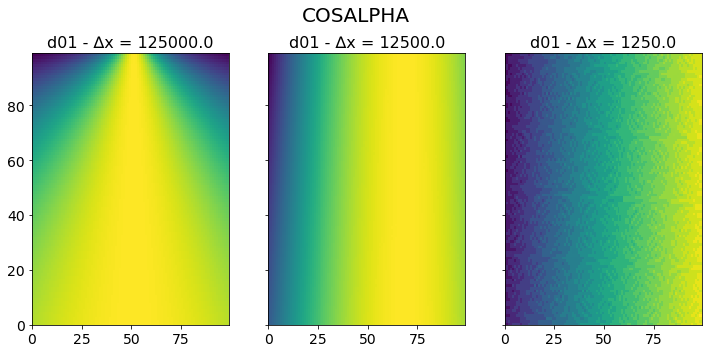

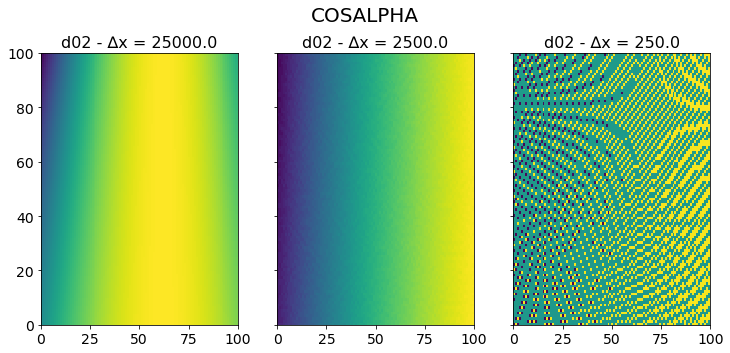

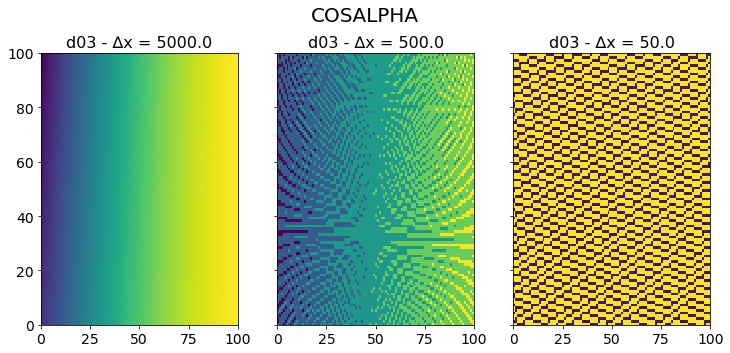

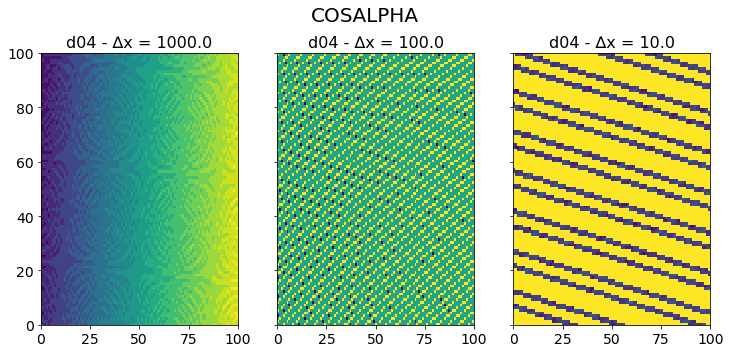

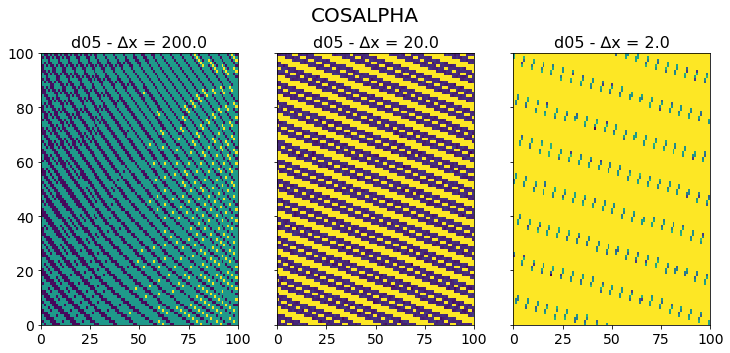

In [7]:
scale_dir = '/glade/scratch/hawbecke/WRF/ALPHA_tests/LAM_30s_pgr5_v4.2_parallel_standardGeog/'
cases = ['low_res','orig_res','high_res']
#cosa_dict = {}
#sina_dict = {}
for dd,dom in enumerate([1,2,3,4,5]):
    fig,ax = plt.subplots(ncols=3,figsize=(12,5),sharex=True,sharey=True)
    #cosa_dict[dom] = {}
    for cc,case in enumerate(cases):
        case_ds = xr.open_dataset('{}{}/geo_em.d0{}.nc'.format(scale_dir,case,dom)).squeeze()
        #cosa_dict[dom][case] = case_ds.COSALPHA
        ax[cc].pcolormesh(case_ds.COSALPHA)
        
        ax[cc].set_title('d0{0} - ∆x = {1:2.1f}'.format(dom,case_ds.DX),size=16)
        ax[cc].tick_params(labelsize=14)
    plt.suptitle('COSALPHA',size=20,y=1.01)
    plt.show()
        
        
    

    

# Local code for COSA and SINA:

In [8]:
def get_rotang(xlon_arr,xlat_arr):
    RAD_PER_DEG = np.pi/180.

    cosa = np.zeros(np.shape(xlon_arr))
    sina = np.zeros(np.shape(xlon_arr))
    atanAf = np.zeros(np.shape(xlon_arr))
    atanBf = np.zeros(np.shape(xlon_arr))

    atanA1 = np.zeros(np.shape(xlon_arr))
    atanA2 = np.zeros(np.shape(xlon_arr))
    dlon_a = np.zeros(np.shape(xlon_arr))

    nx,ny = np.shape(xlat_arr)
    for i in range(0,nx):
        for j in range(0,ny):
            
            if j == 0:
                d_lon = xlon_arr[i,j+1] - xlon_arr[i,j]
            elif j == ny - 1:
                d_lon = xlon_arr[i,j] - xlon_arr[i,j-1]
            else:
                d_lon = xlon_arr[i,j+1] - xlon_arr[i,j-1]
            if d_lon > 180.0:
                d_lon -= 360.0
            elif d_lon < -180.0:
                d_lon += 360.0

            dlon_a[i,j] = d_lon
            
            atanA = -np.cos(xlat_arr[i,j]*RAD_PER_DEG) * (d_lon*RAD_PER_DEG)
            
            if j == 0:
                atanB = (xlat_arr[i,j+1]-xlat_arr[i,j])*RAD_PER_DEG
            elif j == ny - 1:
                atanB = (xlat_arr[i,j]-xlat_arr[i,j-1])*RAD_PER_DEG
            else:
                atanB = (xlat_arr[i,j+1]-xlat_arr[i,j-1])*RAD_PER_DEG

            alpha = np.arctan2(atanA,atanB)
            sina[i,j] = np.sin(alpha)
            cosa[i,j] = np.cos(alpha)
            atanAf[i,j] = atanA
            atanBf[i,j] = atanB
            atanA1[i,j] = -np.cos(xlat_arr[i,j]*RAD_PER_DEG)
            atanA2[i,j] = (d_lon*RAD_PER_DEG)
            
            
    return(sina,cosa,atanAf,atanBf,atanA1,atanA2,dlon_a)

In [4]:
test_dir = '/glade/scratch/hawbecke/WRF/ALPHA_tests/full_test/'
save_dir = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/production/img/'

use_wrf_latlon = False
dt = 'float64'

base_case = 'baseline'
cases = ['overwrite']

doms = [1,2]
#doms = [1,2,3,4]

In [5]:
for cc,case in enumerate(cases):
    for dd,dom in enumerate(doms):
        
        base_in_fname = '{}{}/wrfinput_d0{}'.format(test_dir,base_case,dom)
        new_in_fname = base_in_fname.replace(base_case,case) + '_new'
        base_in = xr.open_dataset(base_in_fname)
        wrf_lat = base_in.XLAT.squeeze().data
        wrf_lon = base_in.XLONG.squeeze().data
        
        nx,ny = np.shape(wrf_lon)
        xlon_int = np.zeros(np.shape(wrf_lon),dtype=dt)
        xlat_int = np.zeros(np.shape(wrf_lat),dtype=dt)
        for jj in range(0,ny):
            xlon_int[:,jj] = np.linspace(wrf_lon[0,jj],wrf_lon[-1,jj],nx, dtype=dt)
        for ii in range(0,nx):
            xlat_int[ii,:] = np.linspace(wrf_lat[ii,0],wrf_lat[ii,-1],nx, dtype=dt)
        
        cosa_dict = {}
        sina_dict = {}
        fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,9),sharex=True,sharey=True)
        for uu,use_wrf_latlon in enumerate([True,False]):
            if use_wrf_latlon:
                xlon_arr = wrf_lon
                xlat_arr = wrf_lat
            else:
                xlon_arr = xlon_int
                xlat_arr = xlat_int        

            transpose_vars = True
            if transpose_vars:
                xlon_arr = xlon_arr.T
                xlat_arr = xlat_arr.T

            sina,cosa,atanAf,atanBf,atanA1,atanA2,dlon_a = get_rotang(xlon_arr,xlat_arr)

            if transpose_vars:
                cosa = cosa.T
                sina = sina.T
                xlat_arr = xlat_arr.T
                xlon_arr = xlon_arr.T
                atanAf = atanAf.T
                atanBf = atanBf.T
                atanA1 = atanA1.T
                atanA2 = atanA2.T

                
            if uu == 0:
                cmin = np.nanmin(cosa)
                cmax = np.nanmax(cosa)
                smin = np.nanmin(sina)
                smax = np.nanmax(sina)
            ax[0,uu].pcolormesh(xlon_arr,xlat_arr,cosa,vmin=cmin,vmax=cmax)
            ax[1,uu].pcolormesh(xlon_arr,xlat_arr,sina,vmin=smin,vmax=smax)

            cosa_dict[uu] = cosa.copy()
            sina_dict[uu] = cosa.copy()
            
            if not use_wrf_latlon:
                base_in.COSALPHA.data[0,:,:] = cosa
                base_in.SINALPHA.data[0,:,:] = sina
            
        dplt1 = ax[0,2].pcolormesh(xlon_arr,xlat_arr,(cosa_dict[1] - cosa_dict[0]))
        dplt2 = ax[1,2].pcolormesh(xlon_arr,xlat_arr,(sina_dict[1] - sina_dict[0]))
        plt.colorbar(dplt1,ax=ax[0,2])
        plt.colorbar(dplt2,ax=ax[1,2])
        plt.show()
        
        base_in.to_netcdf(new_in_fname)
        base_in.close()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'cfgrib', 'gini', 'rasterio']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

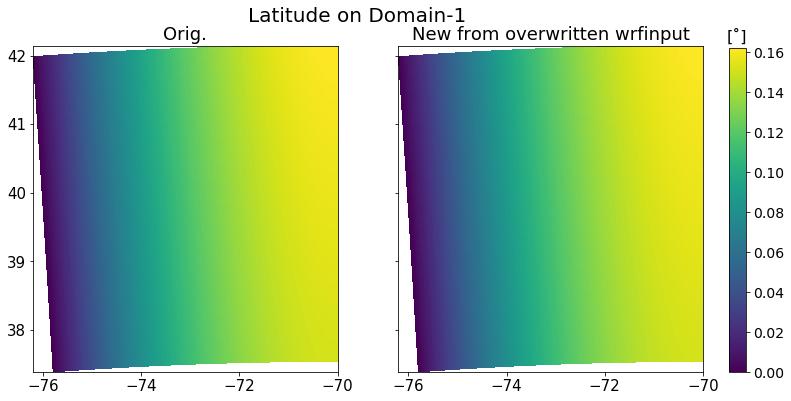

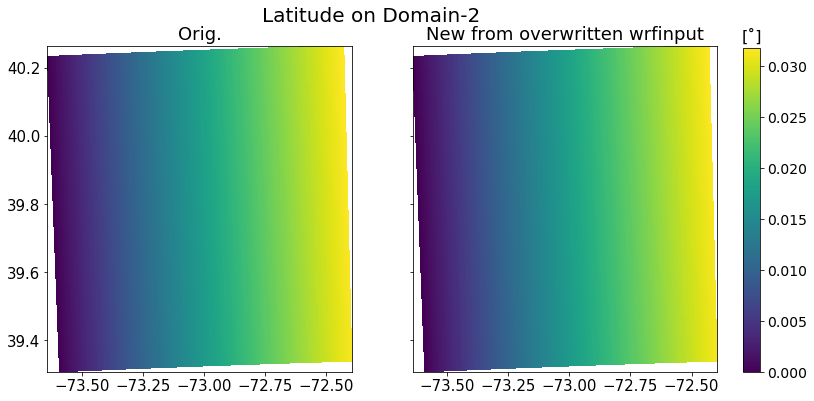

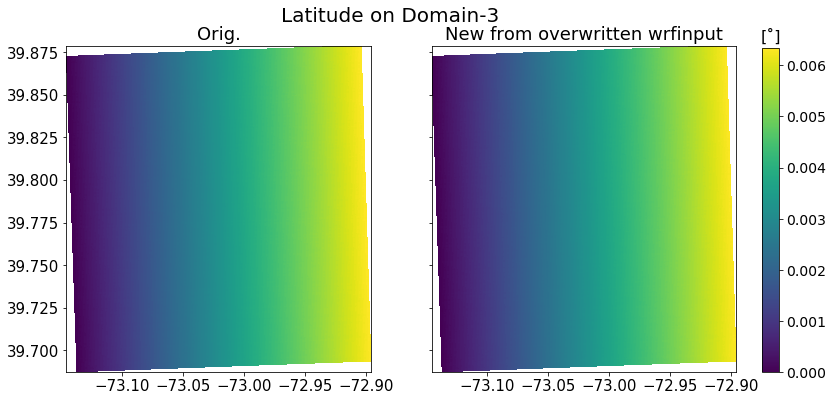

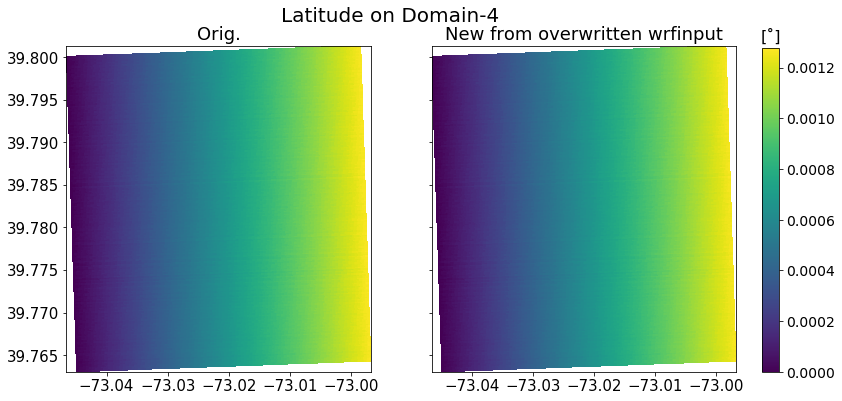

In [11]:
for dd,dom in enumerate([1,2,3,4]):
    orig_wrfin = xr.open_dataset('{}baseline_4dom/wrfinput_d0{}'.format(test_dir,dom)).squeeze()
    new_wrfin  = xr.open_dataset('{}overwrite_4dom/wrfinput_d0{}'.format(test_dir,dom)).squeeze()
    wrf_lat = orig_wrfin.XLAT
    wrf_lon = orig_wrfin.XLONG
    
    orig_cosa = orig_wrfin.XLAT
    new_cosa = new_wrfin.XLAT
    
    orig_cosa = orig_cosa - orig_cosa[:,0]
    new_cosa = new_cosa - new_cosa[:,0]
    
    vmin = np.min([float(orig_cosa.min()),float(new_cosa.min())])
    vmax = np.max([float(orig_cosa.max()),float(new_cosa.max())])
    #print(vmin,vmax)
    
    fig,ax = plt.subplots(ncols=2,figsize=(12,6),sharex=True,sharey=True)
    cplt = ax[0].pcolormesh(wrf_lon,wrf_lat,orig_cosa,vmin=vmin)
    ax[1].pcolormesh(wrf_lon,wrf_lat,new_cosa,vmax=vmax)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=15)
    plt.suptitle('Latitude on Domain-{}'.format(dom),size=20,y=0.97)
    ax[0].set_title('Orig.',size=18)
    ax[1].set_title('New from overwritten wrfinput',size=18)
    
    cax  = fig.add_axes([0.93,0.125,0.02,0.75])
    cbar = plt.colorbar(cplt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[˚]',size=16)
    
    plt.show()


    
    

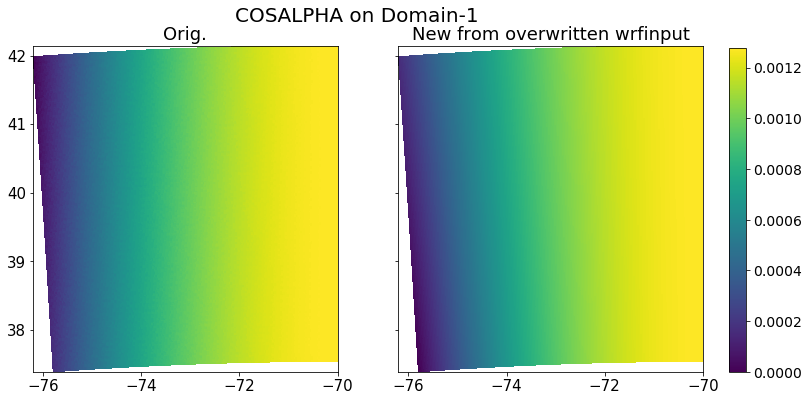

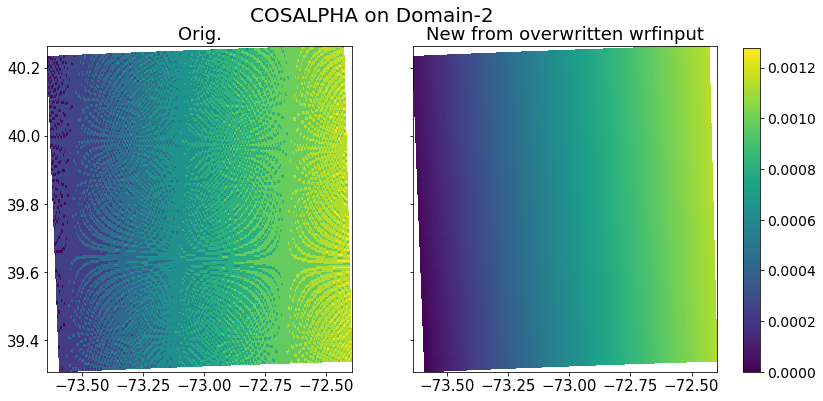

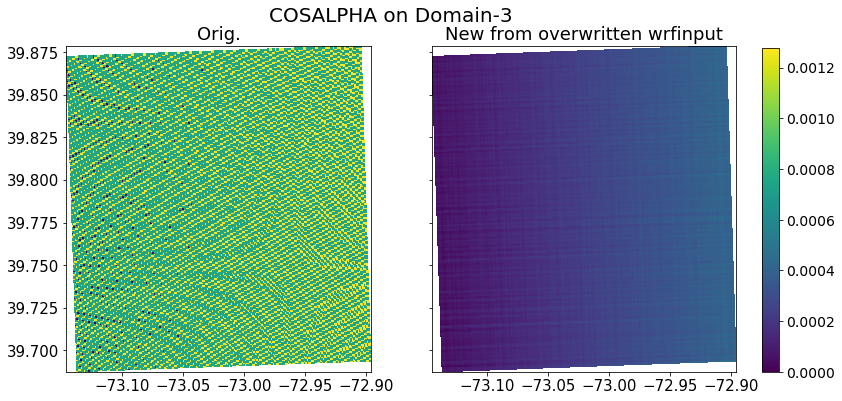

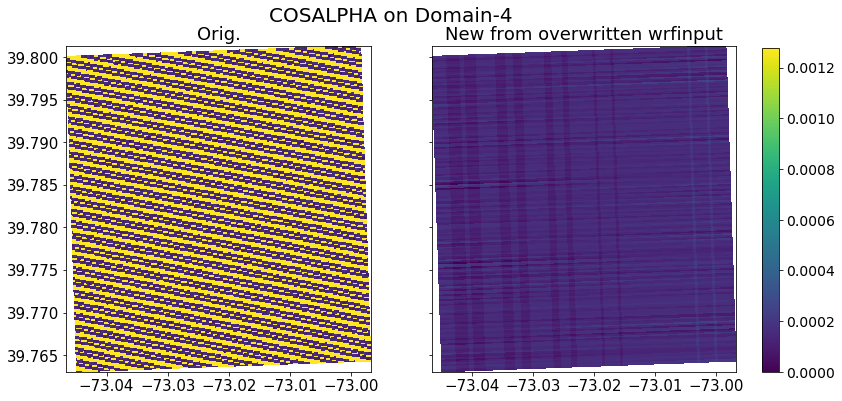

In [12]:
for dd,dom in enumerate([1,2,3,4]):
    orig_wrfin = xr.open_dataset('{}baseline_4dom/wrfinput_d0{}'.format(test_dir,dom)).squeeze()
    new_wrfin  = xr.open_dataset('{}overwrite_4dom/wrfinput_d0{}'.format(test_dir,dom)).squeeze()
    wrf_lat = orig_wrfin.XLAT
    wrf_lon = orig_wrfin.XLONG
    
    orig_cosa = orig_wrfin.COSALPHA
    new_cosa = new_wrfin.COSALPHA
    
    vmin = np.min([float(orig_cosa.min()),float(new_cosa.min())])
    vmax = np.max([float(orig_cosa.max()),float(new_cosa.max())])
    #print(vmin,vmax)
    
    fig,ax = plt.subplots(ncols=2,figsize=(12,6),sharex=True,sharey=True)
    ax[0].pcolormesh(wrf_lon,wrf_lat,orig_cosa,vmin=vmin)
    ax[1].pcolormesh(wrf_lon,wrf_lat,new_cosa,vmax=vmax)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=15)
    plt.suptitle('COSALPHA on Domain-{}'.format(dom),size=20,y=0.97)
    ax[0].set_title('Orig.',size=18)
    ax[1].set_title('New from overwritten wrfinput',size=18)
    
    cax  = fig.add_axes([0.93,0.125,0.02,0.75])
    cbar = plt.colorbar(cplt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    #cbar.ax.set_title('[˚]',size=16)
    
    plt.show()


    
    

In [13]:
base_case = 'baseline'
cases = ['overwrite']

In [14]:
cases_of_interest = [base_case] + cases

wrfout_files = sorted(glob.glob('{}{}/wrfout_d0{}*'.format(test_dir,cases[0],1)))
for ww,wf in enumerate(wrfout_files):
    wrfout_files[ww] = wf.split('/')[-1].replace('d01','d0{}')

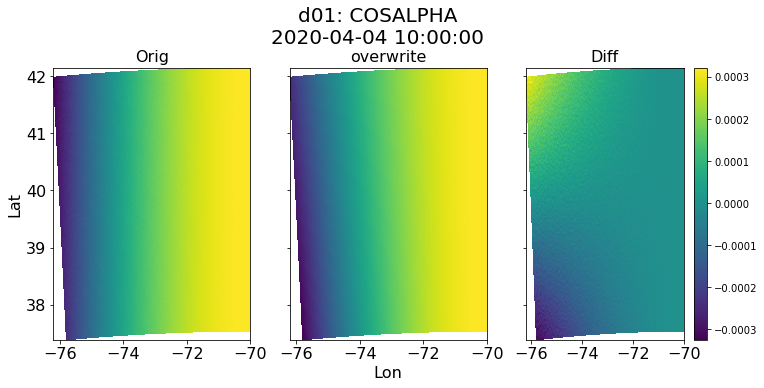

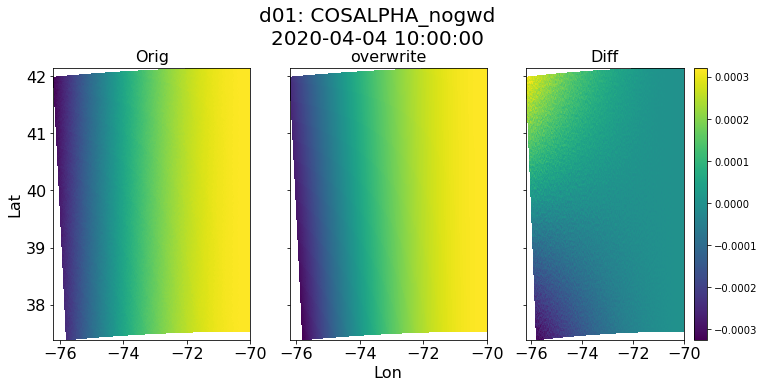

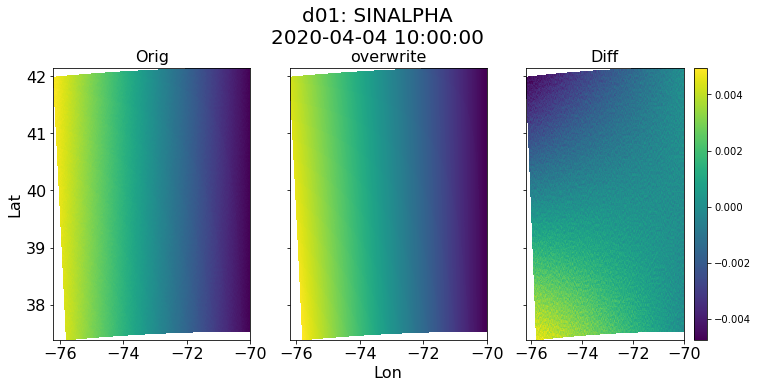

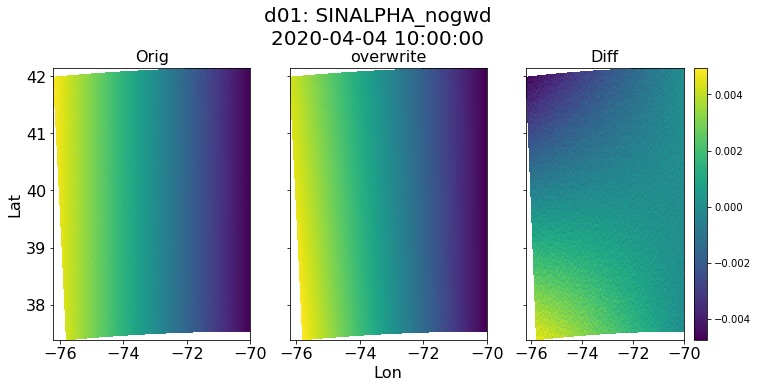

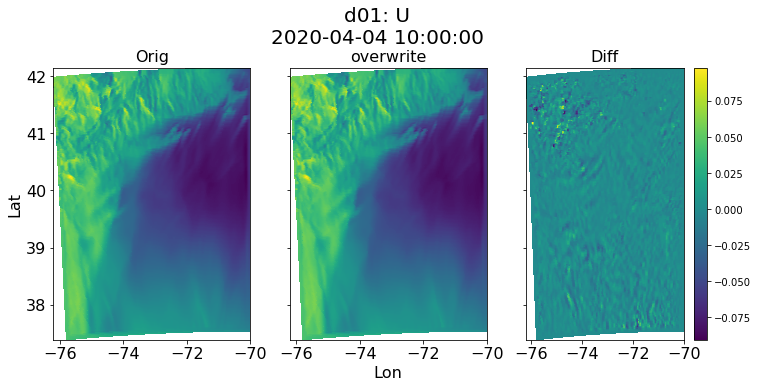

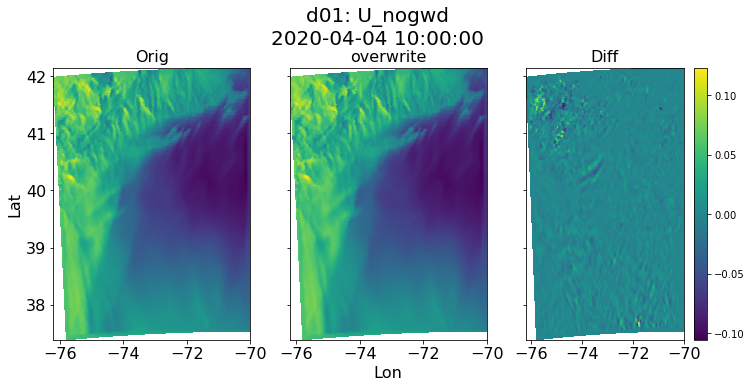

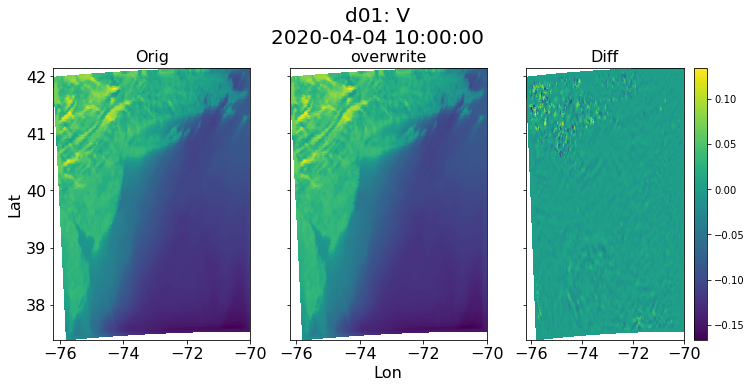

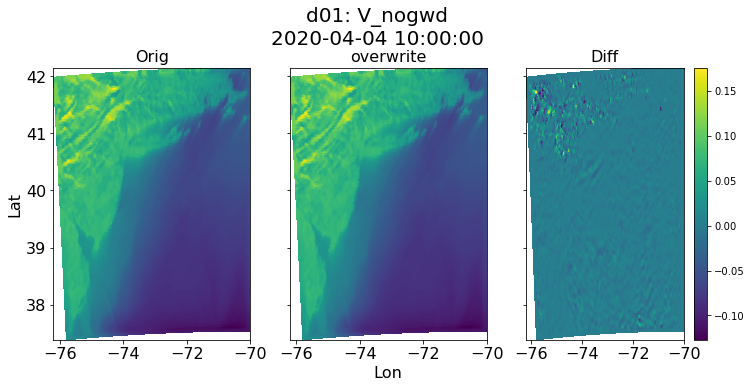

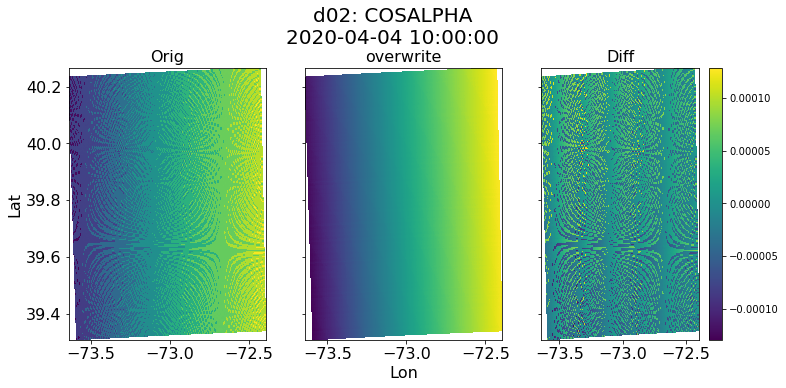

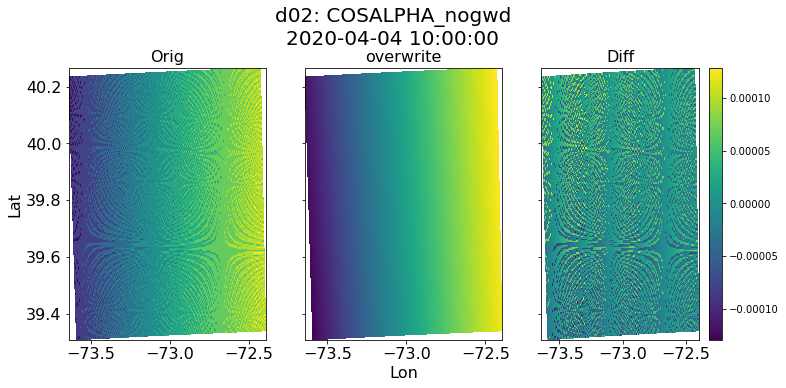

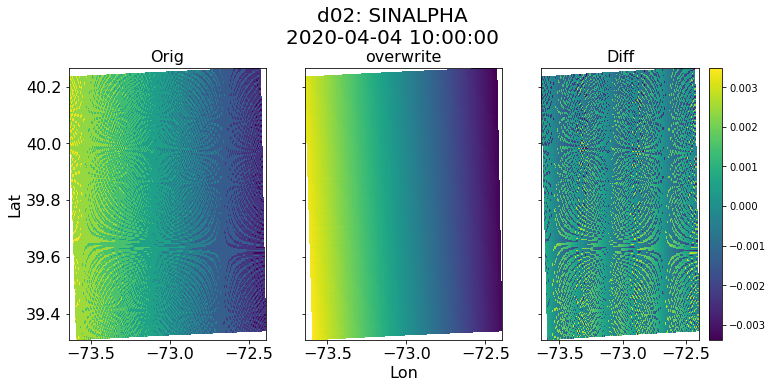

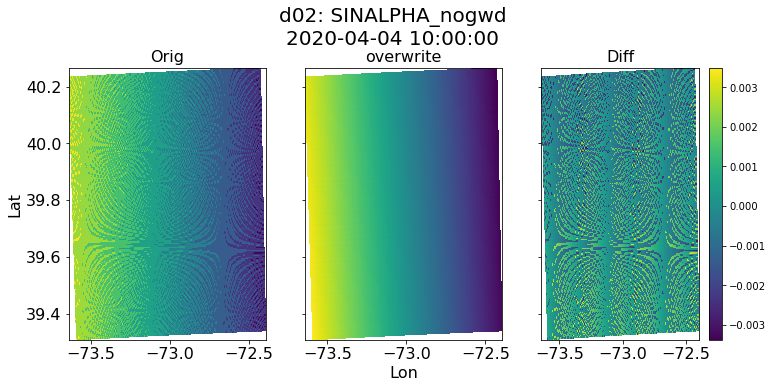

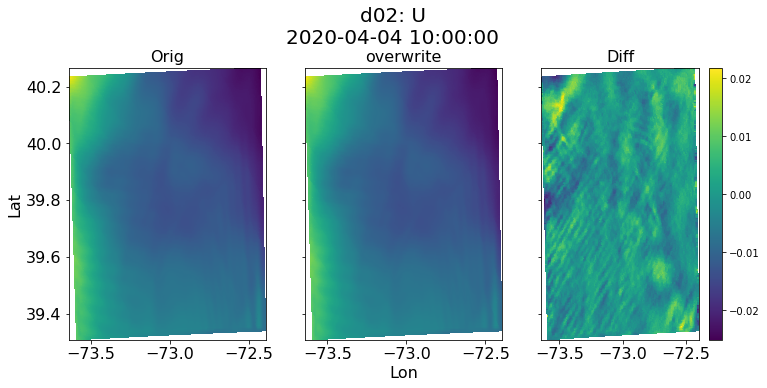

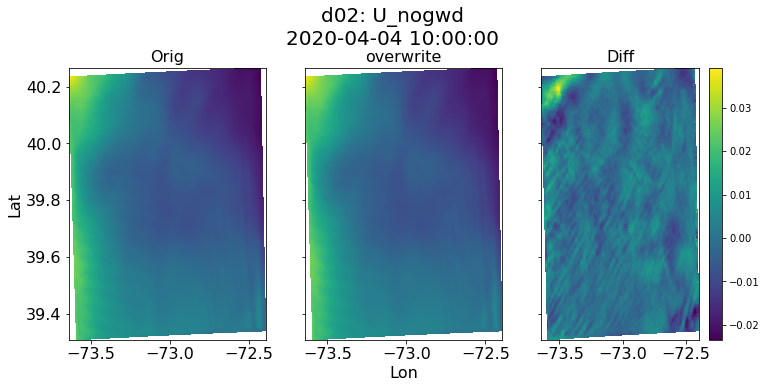

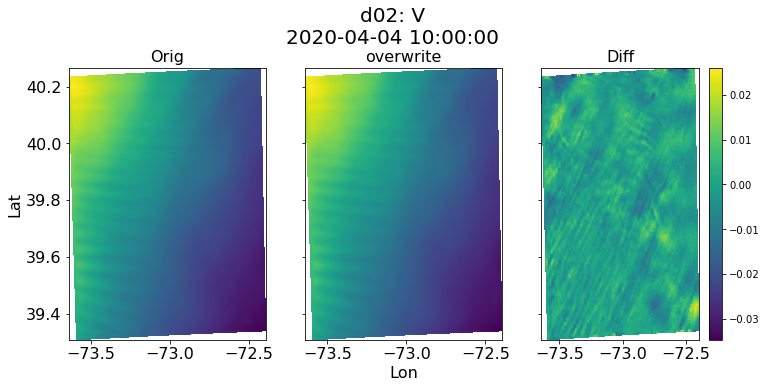

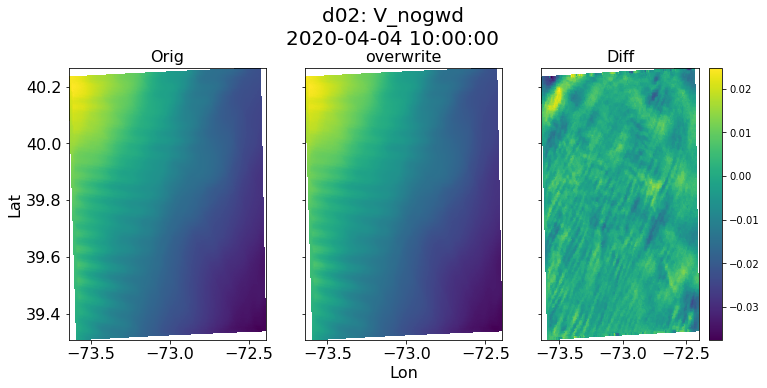

In [15]:
for dd,dom in enumerate([1,2]):
    for varn in ['COSALPHA','SINALPHA','U','V']:
        for base_str in ['','_nogwd']:
            wrfout_file = wrfout_files[4].format(dom)
            base_ds = xr.open_dataset('{}{}/{}'.format(test_dir,base_case+base_str,wrfout_file)).squeeze()
            wrf_lat = base_ds.XLAT
            wrf_lon = base_ds.XLONG
            base_var = base_ds[varn]
            if varn == 'U': base_var = (base_var[0,:,1:] + base_var[0,:,:-1])*0.5
            if varn == 'V': base_var = (base_var[0,1:,:] + base_var[0,:-1,:])*0.5

            for cc,case in enumerate(cases):
                fig,ax = plt.subplots(ncols=3,figsize=(12,5),sharex=True,sharey=True)
                wrf_ds = xr.open_dataset('{}{}/{}'.format(test_dir,case+base_str,wrfout_file)).squeeze()

                wrf_var = wrf_ds[varn]
                if varn == 'U': wrf_var = (wrf_var[0,:,1:] + wrf_var[0,:,:-1])*0.5
                if varn == 'V': wrf_var = (wrf_var[0,1:,:] + wrf_var[0,:-1,:])*0.5
                ax[0].pcolormesh(wrf_lon,wrf_lat,base_var)

                ax[1].pcolormesh(wrf_lon,wrf_lat,wrf_var)
                dplt = ax[2].pcolormesh(wrf_lon,wrf_lat,wrf_var-base_var)
                plt.colorbar(dplt,ax=ax[2])
                for axi in range(0,3):
                    ax[axi].tick_params(labelsize=16)
                ax[0].set_title('Orig',size=16)
                ax[1].set_title(case,size=16)
                ax[2].set_title('Diff',size=16)
                ax[1].set_xlabel('Lon',size=16)
                ax[0].set_ylabel('Lat',size=16)
                wrf_time = ' '.join(wrfout_file.split('_')[-2:])
                plt.suptitle('d0{}: {}{}\n{}'.format(dom,varn,base_str,wrf_time),size=20,y=1.05)
                plt.show()

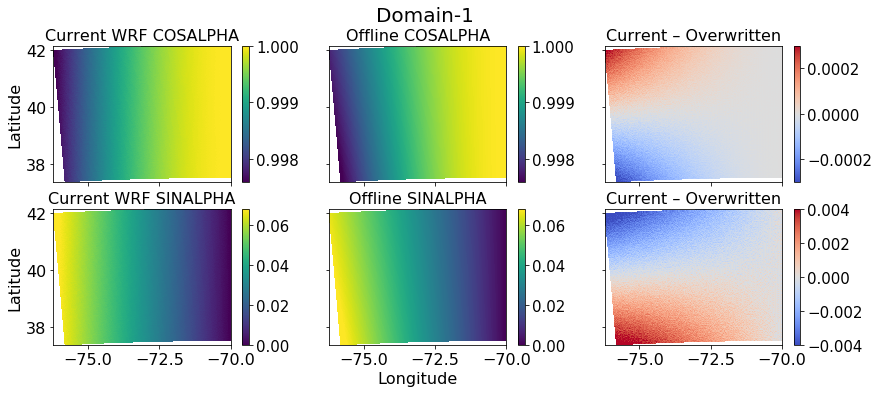

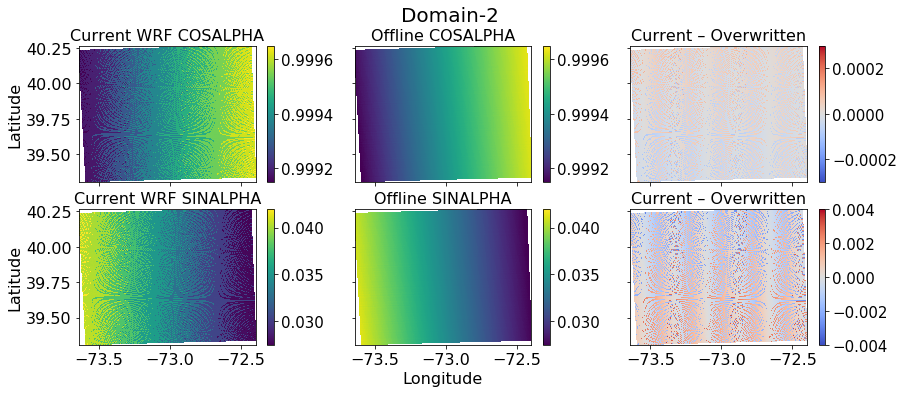

In [16]:
base_str = ''
for dd,dom in enumerate([1,2]):
    fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(14,5.5),sharex=True,sharey=True)
    for vv,varn in enumerate(['COSALPHA','SINALPHA']):
        wrfout_file = wrfout_files[4].format(dom)
        wrfout_path = '{}{}/{}'.format(test_dir,base_case+base_str,wrfout_file)
        base_ds = xr.open_dataset(wrfout_path).squeeze()
        wrf_lat = base_ds.XLAT
        wrf_lon = base_ds.XLONG
        base_var = base_ds[varn]

        for cc,case in enumerate(cases):
            wrfout_path = '{}{}/{}'.format(test_dir,case+base_str,wrfout_file)
            wrf_ds = xr.open_dataset(wrfout_path).squeeze()

            wrf_var = wrf_ds[varn]
            if varn == 'U': wrf_var = (wrf_var[0,:,1:] + wrf_var[0,:,:-1])*0.5
            if varn == 'V': wrf_var = (wrf_var[0,1:,:] + wrf_var[0,:-1,:])*0.5
            
            if vv == 0:
                dint = 0.0003
                if dd == 0:
                    pmin = 0.9976
                    pmax = 1.0
                else:
                    pmin = 0.99915
                    pmax = 0.99965
            else:
                dint = 0.004
                if dd == 0:
                    pmin = 0.0
                    pmax = 0.068
                else:
                    pmin = 0.0274
                    pmax = 0.042
            
            base_plt = ax[vv,0].pcolormesh(wrf_lon,wrf_lat,base_var,
                                           vmin=pmin,vmax=pmax)
            new_plt  = ax[vv,1].pcolormesh(wrf_lon,wrf_lat,wrf_var,
                                           vmin=pmin,vmax=pmax
                                          )
            a_cbar = plt.colorbar(base_plt,ax=ax[vv,0])
            b_cbar = plt.colorbar(new_plt,ax=ax[vv,1])
            a_cbar.ax.tick_params(labelsize=15)
            b_cbar.ax.tick_params(labelsize=15)

            dplt = ax[vv,2].pcolormesh(wrf_lon,wrf_lat,wrf_var-base_var,
                                       cmap=plt.cm.coolwarm,
                                       vmin=-dint,vmax=dint
                                      )
            d_cbar = plt.colorbar(dplt,ax=ax[vv,2])
            d_cbar.ax.tick_params(labelsize=15)

            for axi in range(0,3):
                ax[vv,axi].tick_params(labelsize=16)
                ax[vv,axi].set_aspect('equal')
            ax[vv,0].set_title('Current WRF {}'.format(varn),size=16)
            ax[vv,1].set_title('Offline {}'.format(varn),size=16)
            ax[vv,2].set_title('Current – Overwritten',size=16)
            ax[vv,0].set_ylabel('Latitude',size=16)
            wrf_time = ' '.join(wrfout_file.split('_')[-2:])
    ax[1,1].set_xlabel('Longitude',size=16)
    plt.suptitle('Domain-{}'.format(dom),size=20,y=0.98)
    plt.show()

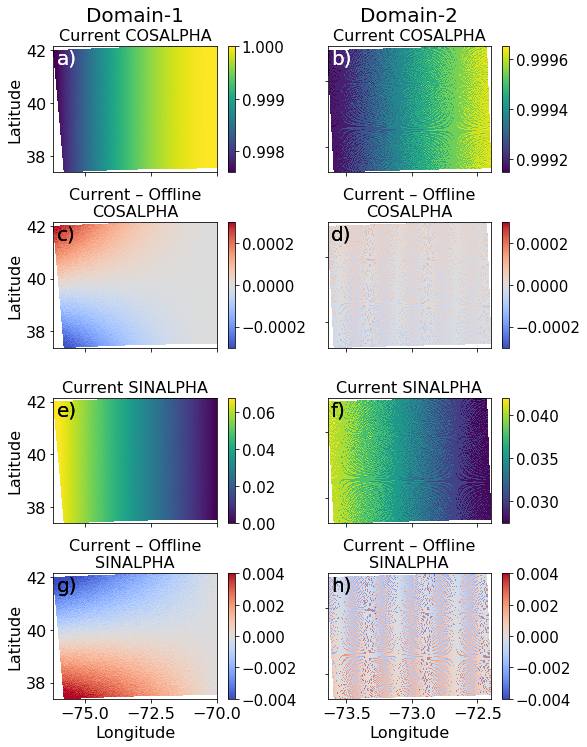

In [17]:
base_str = ''
fig,ax = plt.subplots(ncols=2,nrows=4,figsize=(9,12))#,sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.4)
letter_count = 0
for dd,dom in enumerate([1,2]):
    wrfout_file = wrfout_files[4].format(dom)
    wrfout_path = '{}{}/{}'.format(test_dir,base_case+base_str,wrfout_file)
    base_ds = xr.open_dataset(wrfout_path).squeeze()
    wrf_lat = base_ds.XLAT
    wrf_lon = base_ds.XLONG
    wrfout_path = '{}{}/{}'.format(test_dir,case+base_str,wrfout_file)
    wrf_ds = xr.open_dataset(wrfout_path).squeeze()
    for vv,varn in enumerate(['COSALPHA','SINALPHA']):

        base_var = base_ds[varn]
        wrf_var = wrf_ds[varn]

        if vv == 0:
            dint = 0.0003
            if dd == 0:
                pmin = 0.9976
                pmax = 1.0
            else:
                pmin = 0.99915
                pmax = 0.99965
        else:
            dint = 0.004
            if dd == 0:
                pmin = 0.0
                pmax = 0.068
            else:
                pmin = 0.0274
                pmax = 0.042

        plt_ax = vv*2
        base_plt = ax[plt_ax,dd].pcolormesh(wrf_lon,wrf_lat,base_var,
                                            vmin=pmin,vmax=pmax,
                                            rasterized=True)

        a_cbar = plt.colorbar(base_plt,ax=ax[plt_ax,dd])
        a_cbar.ax.tick_params(labelsize=15)

        dplt = ax[plt_ax + 1,dd].pcolormesh(wrf_lon,wrf_lat,wrf_var-base_var,
                                            cmap=plt.cm.coolwarm,
                                            vmin=-dint,vmax=dint,
                                            rasterized=True
                                            )
        d_cbar = plt.colorbar(dplt,ax=ax[plt_ax + 1,dd])
        d_cbar.ax.tick_params(labelsize=15)
        
        for axi in range(0,4):
            letter_count = dd + axi*2
            fc = 'k'
            if axi == 0:
                fc = 'w'
            ax[axi,dd].text(0.02,0.98,'{})'.format(ascii_lowercase[letter_count]),
                            size=20,color=fc,
                            ha='left',va='top',
                            transform=ax[axi,dd].transAxes)
            if dd == 0:
                ax[axi,dd].tick_params(labelleft=True)
            else:
                ax[axi,dd].tick_params(labelleft=False)
            if axi == 3:
                ax[axi,dd].tick_params(labelbottom=True)
                ax[axi,dd].set_xlabel('Longitude',size=16)

            else:
                ax[axi,dd].tick_params(labelbottom=False)
            ax[axi,0].set_ylabel('Latitude',size=16)

            ax[axi,dd].tick_params(labelsize=16)
            ax[axi,dd].set_aspect('equal')
        ax[plt_ax,dd].set_title('Current {}'.format(varn),size=16)
        ax[plt_ax + 1,dd].set_title('Current – Offline\n{}'.format(varn),size=16)
        wrf_time = ' '.join(wrfout_file.split('_')[-2:])
    ax[0,dd].text(0.5,1.2,'Domain-{}'.format(dom),size=20,
                  ha='center',transform=ax[0,dd].transAxes)
fig_name = '{}Appendix_Diffs'.format(save_dir)
for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type)
plt.show()

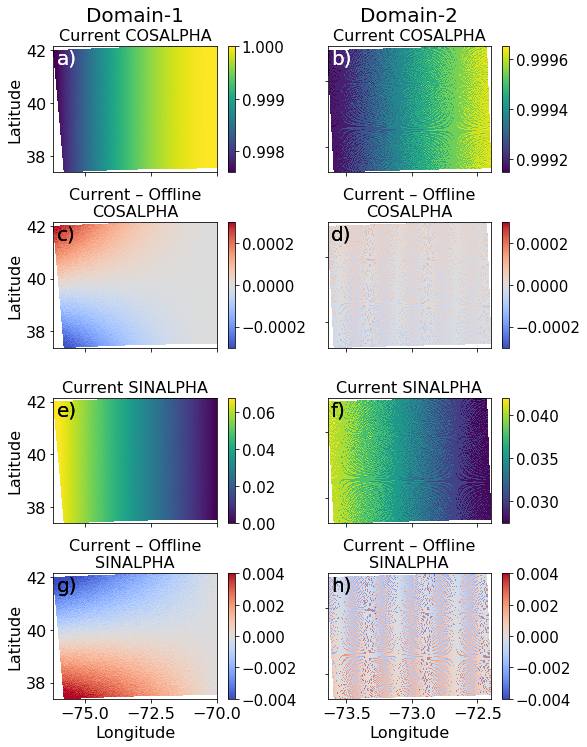

In [17]:
base_str = ''
fig,ax = plt.subplots(ncols=2,nrows=4,figsize=(9,12))#,sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.4)
letter_count = 0
for dd,dom in enumerate([1,2]):
    wrfout_file = wrfout_files[4].format(dom)
    wrfout_path = '{}{}/{}'.format(test_dir,base_case+base_str,wrfout_file)
    base_ds = xr.open_dataset(wrfout_path).squeeze()
    wrf_lat = base_ds.XLAT
    wrf_lon = base_ds.XLONG
    wrfout_path = '{}{}/{}'.format(test_dir,case+base_str,wrfout_file)
    wrf_ds = xr.open_dataset(wrfout_path).squeeze()
    for vv,varn in enumerate(['COSALPHA','SINALPHA']):

        base_var = base_ds[varn]
        wrf_var = wrf_ds[varn]

        if vv == 0:
            dint = 0.0003
            if dd == 0:
                pmin = 0.9976
                pmax = 1.0
            else:
                pmin = 0.99915
                pmax = 0.99965
        else:
            dint = 0.004
            if dd == 0:
                pmin = 0.0
                pmax = 0.068
            else:
                pmin = 0.0274
                pmax = 0.042

        plt_ax = vv*2
        base_plt = ax[plt_ax,dd].pcolormesh(wrf_lon,wrf_lat,base_var,
                                            vmin=pmin,vmax=pmax,
                                            rasterized=True)

        a_cbar = plt.colorbar(base_plt,ax=ax[plt_ax,dd])
        a_cbar.ax.tick_params(labelsize=15)

        dplt = ax[plt_ax + 1,dd].pcolormesh(wrf_lon,wrf_lat,wrf_var-base_var,
                                            cmap=plt.cm.coolwarm,
                                            vmin=-dint,vmax=dint,
                                            rasterized=True
                                            )
        d_cbar = plt.colorbar(dplt,ax=ax[plt_ax + 1,dd])
        d_cbar.ax.tick_params(labelsize=15)
        
        for axi in range(0,4):
            letter_count = dd + axi*2
            fc = 'k'
            if axi == 0:
                fc = 'w'
            ax[axi,dd].text(0.02,0.98,'{})'.format(ascii_lowercase[letter_count]),
                            size=20,color=fc,
                            ha='left',va='top',
                            transform=ax[axi,dd].transAxes)
            if dd == 0:
                ax[axi,dd].tick_params(labelleft=True)
            else:
                ax[axi,dd].tick_params(labelleft=False)
            if axi == 3:
                ax[axi,dd].tick_params(labelbottom=True)
                ax[axi,dd].set_xlabel('Longitude',size=16)

            else:
                ax[axi,dd].tick_params(labelbottom=False)
            ax[axi,0].set_ylabel('Latitude',size=16)

            ax[axi,dd].tick_params(labelsize=16)
            ax[axi,dd].set_aspect('equal')
        ax[plt_ax,dd].set_title('Current {}'.format(varn),size=16)
        ax[plt_ax + 1,dd].set_title('Current – Offline\n{}'.format(varn),size=16)
        wrf_time = ' '.join(wrfout_file.split('_')[-2:])
    ax[0,dd].text(0.5,1.2,'Domain-{}'.format(dom),size=20,
                  ha='center',transform=ax[0,dd].transAxes)
fig_name = '{}Appendix_Diffs'.format(save_dir)
for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type)
plt.show()

# Error quantification:

In [84]:
wrf_dict = {}
for dd,dom in enumerate([1,2]):
    for ww,wrfout_file in enumerate(wrfout_files[:]):
        wrf_time = pd.to_datetime(' '.join(wrfout_file.split('_')[-2:]))
        wrfout_file = wrfout_file.format(dom)
        base_ds = xr.open_dataset('{}{}/{}'.format(test_dir,base_case,wrfout_file)).squeeze()
        fix_ds = xr.open_dataset('{}{}/{}'.format(test_dir,cases[0],wrfout_file)).squeeze()
        if ww == 0:
            wrf_lat = base_ds.XLAT
            wrf_lon = base_ds.XLONG

        base_u = base_ds['U']
        fix_u  = fix_ds['U']
        base_v = base_ds['V']
        fix_v  = fix_ds['V']
        base_u = (base_u[:,:,1:] + base_u[:,:,:-1])*0.5
        fix_u  = (fix_u[:,:,1:] + fix_u[:,:,:-1])*0.5
        base_v = (base_v[:,1:,:] + base_v[:,:-1,:])*0.5
        fix_v  = (fix_v[:,1:,:] + fix_v[:,:-1,:])*0.5
        
        z = (base_ds.PH + base_ds.PHB)/9.81 - base_ds.HGT
        z = z.mean(dim=['south_north','west_east'])
        zs = 0.5*(z[1:] + z[:-1])
        zs.name = 'height'
        zs = zs.rename({'bottom_top_stag':'bottom_top'})
        zs = zs.expand_dims({'datetime':[wrf_time]})
        
        base_u = base_u.rename({'west_east_stag':'west_east'}).expand_dims({'datetime':[wrf_time],'case':['base']})
        base_v = base_v.rename({'south_north_stag':'south_north'}).expand_dims({'datetime':[wrf_time],'case':['base']})
        fix_u = fix_u.rename({'west_east_stag':'west_east'}).expand_dims({'datetime':[wrf_time],'case':['fix']})
        fix_v = fix_v.rename({'south_north_stag':'south_north'}).expand_dims({'datetime':[wrf_time],'case':['fix']})
        
        base_vel = np.sqrt((base_u**2 + base_v**2))
        base_vel.name = 'wspd'
        fix_vel = np.sqrt((fix_u**2 + fix_v**2))
        fix_vel.name = 'wspd'
        
        dom_ds = xr.merge([base_u,base_v,base_vel,fix_u,fix_v,fix_vel,zs])
        dom_ds = dom_ds.drop(['XTIME'])

        if ww == 0:
            dom_ds_f = dom_ds.copy()
        else:
            dom_ds_f = xr.merge([dom_ds,dom_ds_f])
    dom_ds_f['height'] = dom_ds_f.height.mean(dim='datetime')
    dom_ds_f = dom_ds_f.assign_coords({'height':dom_ds_f.height})
    wrf_dict[dom] = dom_ds_f

            


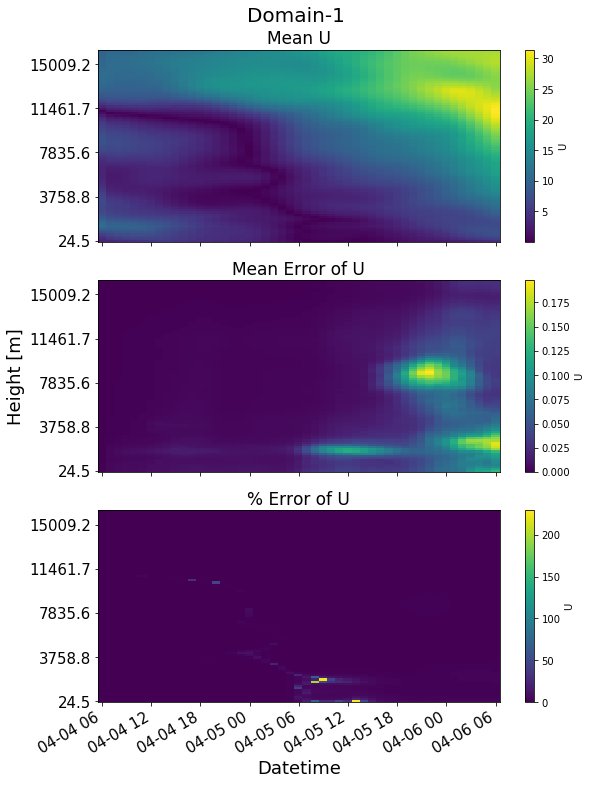

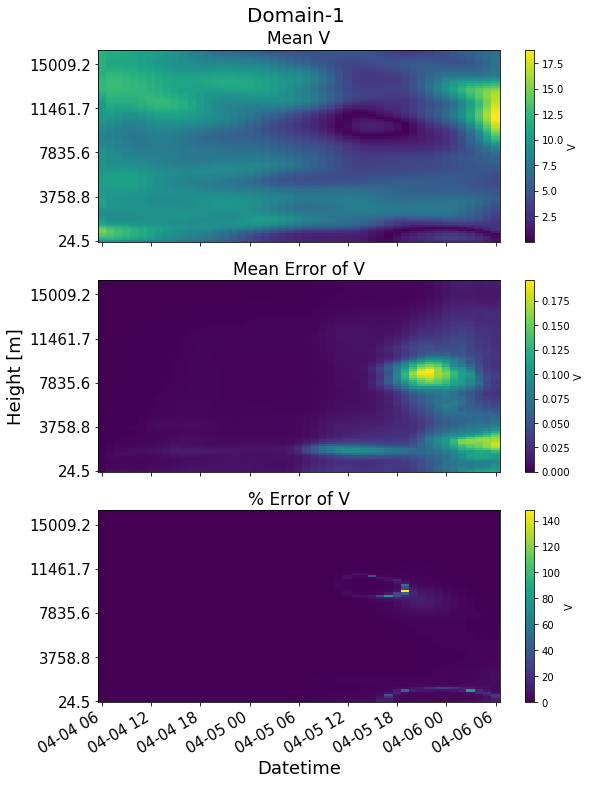

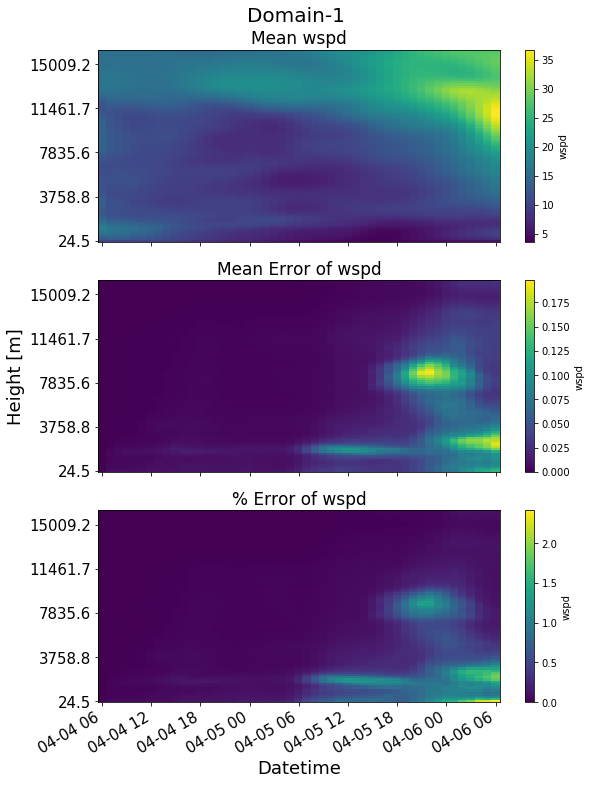

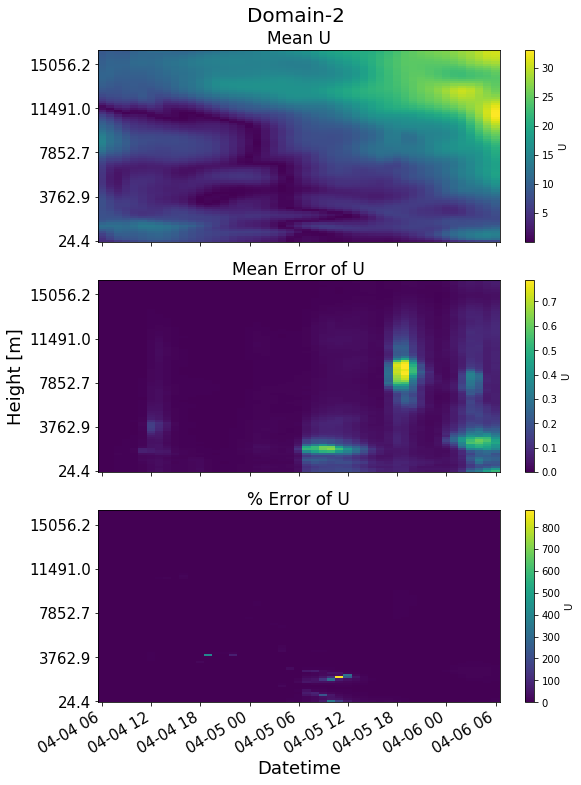

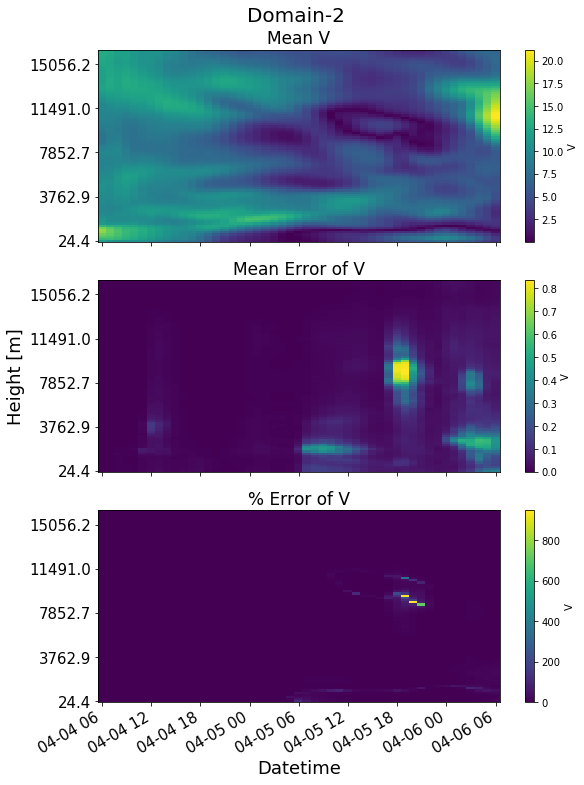

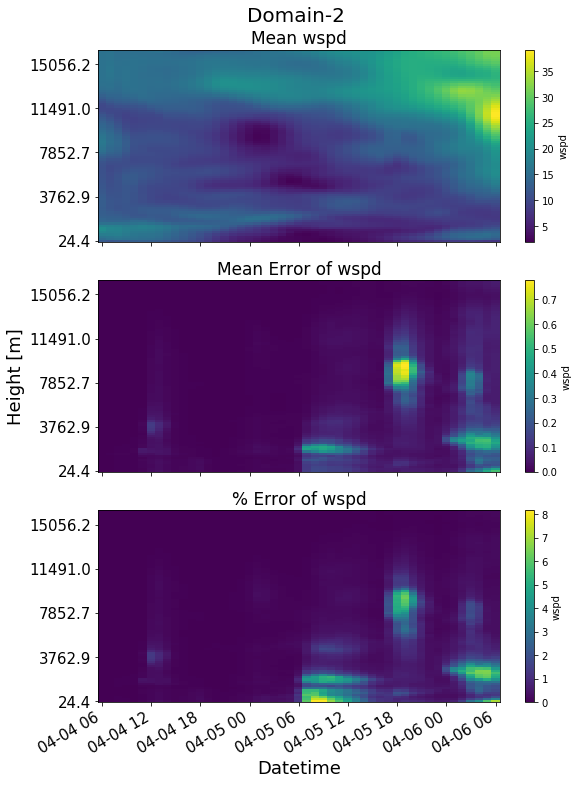

In [85]:
error_dict = {}
for dd,dom in enumerate([1,2]):
    
    error_dict[dom] = {}
    ptimes = []
    dom_ds = wrf_dict[dom].copy()
    err_ds = np.sqrt((dom_ds.sel(case='fix') - dom_ds.sel(case='base'))**2)
    for vv,varn in enumerate(['U','V','wspd']):
        fig,ax = plt.subplots(nrows=3,figsize=(9,12),sharey=True,sharex=True)
        mean_wspd = dom_ds[varn].sel(case='base').mean(dim=['south_north','west_east'])
        mean_wspd = np.abs(mean_wspd)
        mean_err = err_ds[varn].mean(dim=['south_north','west_east'])
        pct_err = 100.0*(mean_err/mean_wspd)

        mean_wspd.plot(y='bottom_top',ax=ax[0])
        ax[0].set_title('Mean {}'.format(varn),size=17)
        mean_err.plot(y='bottom_top',ax=ax[1])
        ax[1].set_title('Mean Error of {}'.format(varn),size=17)
        pct_err.plot(y='bottom_top',ax=ax[2])
        ax[2].set_title('% Error of {}'.format(varn),size=17)

        for axi in range(0,3):
            yint = 20
            ax[axi].set_yticks(mean_wspd.bottom_top.data[::yint])
            ax[axi].set_yticklabels(pct_err.height.round(decimals=1).data[::yint])

            ax[axi].tick_params(labelsize=15)
            xlbl,ylbl = '',''
            if axi == 1: ylbl = 'Height [m]'
            if axi == 2: xlbl = 'Datetime'

            ax[axi].set_ylabel(ylbl,size=18)
            ax[axi].set_xlabel(xlbl,size=18)
        plt.suptitle('Domain-{}'.format(dom),size=20,y=0.93,x=0.43)
        plt.show()


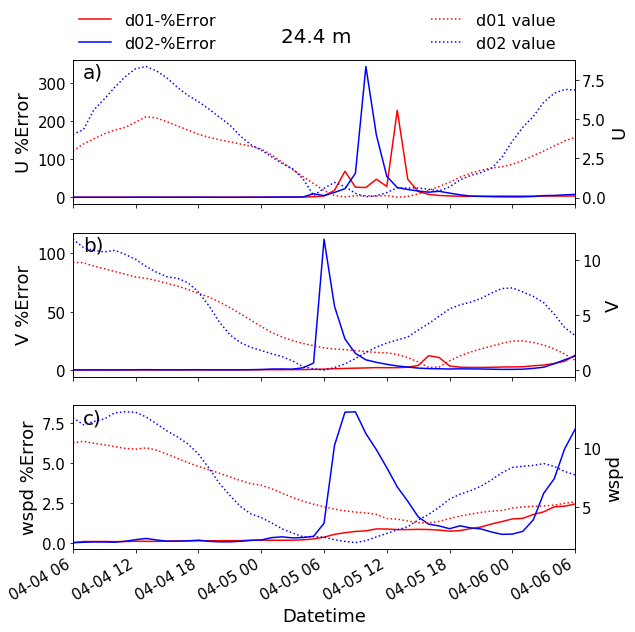

In [117]:
fig,ax = plt.subplots(nrows=3,figsize=(9,9),sharey=False,sharex=True)
tax = []
for axi in range(0,len(ax)): tax += [ax[axi].twinx()]

dom_colors = {1:'r',2:'b'}

lvl = 0

for vv,varn in enumerate(['U','V','wspd']):
    for dd,dom in enumerate([1,2]):
    
        dom_ds = wrf_dict[dom].copy()
        err_ds = np.sqrt((dom_ds.sel(case='fix') - dom_ds.sel(case='base'))**2)
        mean_wspd = dom_ds[varn].sel(case='base').mean(dim=['south_north','west_east'])
        mean_wspd = np.abs(mean_wspd)
        mean_err = err_ds[varn].mean(dim=['south_north','west_east'])
        pct_err = 100.0*(mean_err/mean_wspd)

        mean_wspd = mean_wspd.sel(bottom_top=lvl)
        mean_err = mean_err.sel(bottom_top=lvl)
        pct_err = pct_err.sel(bottom_top=lvl)

        #mean_wspd.plot(ax=ax[vv],label='mean',c='b')
        #mean_err.plot(ax=ax[vv],label='error',c='k')
        pct_err.plot(ax=ax[vv],label='d0{}-%Error'.format(dom),c=dom_colors[dom])
        mean_wspd.plot(ax=tax[vv],c=dom_colors[dom],ls=':',label='d0{} value'.format(dom,varn))
        
    #ax[vv].set_title('{}'.format(varn),size=17)
    ax[vv].tick_params(labelsize=15)
    ax[vv].set_ylabel('{} %Error'.format(varn),size=18)
    ax[vv].set_title('',size=18)
    ax[vv].set_xlim(dom_ds.datetime[0].data,dom_ds.datetime[-1].data)
    tax[vv].tick_params(labelsize=15)
    tax[vv].set_ylabel(varn,size=18)
    tax[vv].set_title('',size=18)
    if vv < 2:
        ax[vv].set_xlabel('')
    else:
        ax[vv].set_xlabel('Datetime',size=18)
        
    ax[vv].text(0.02,0.98,'{})'.format(ascii_lowercase[vv]),
                size=20,color='k',
                ha='left',va='top',
                transform=ax[vv].transAxes)

z = float(dom_ds.height.sel(bottom_top=lvl).data)
plt.suptitle('{0:3.1f} m'.format(z),size=20,y=0.93,x=0.5)
ax[0].legend(frameon=False,fontsize=16,loc=(0.0,1.02))
tax[0].legend(frameon=False,fontsize=16,loc=(0.70,1.02))
fig_name = '{}Appendix_Error'.format(save_dir)
for save_type in ['.png','.pdf']: plt.savefig(fig_name+save_type)
plt.show()


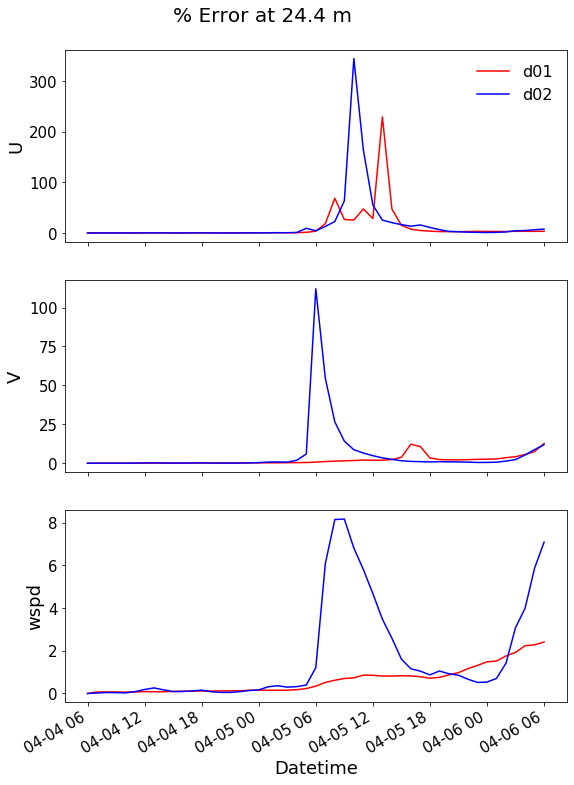

In [18]:
fig,ax = plt.subplots(nrows=3,figsize=(9,12),sharey=False,sharex=True)
dom_colors = {1:'r',2:'b'}

lvl = 0

for vv,varn in enumerate(['U','V','wspd']):
    for dd,dom in enumerate([1,2]):
    
        dom_ds = wrf_dict[dom].copy()
        err_ds = np.sqrt((dom_ds.sel(case='fix') - dom_ds.sel(case='base'))**2)
        mean_wspd = dom_ds[varn].sel(case='base').mean(dim=['south_north','west_east'])
        mean_wspd = np.abs(mean_wspd)
        mean_err = err_ds[varn].mean(dim=['south_north','west_east'])
        pct_err = 100.0*(mean_err/mean_wspd)

        mean_wspd = mean_wspd.sel(bottom_top=lvl)
        mean_err = mean_err.sel(bottom_top=lvl)
        pct_err = pct_err.sel(bottom_top=lvl)

        #mean_wspd.plot(ax=ax[vv],label='mean',c='b')
        #mean_err.plot(ax=ax[vv],label='error',c='k')
        pct_err.plot(ax=ax[vv],label='d0{}'.format(dom),c=dom_colors[dom])
        
    #ax[vv].set_title('{}'.format(varn),size=17)
    ax[vv].tick_params(labelsize=15)
    ax[vv].set_ylabel(varn,size=18)
    ax[vv].set_title('',size=18)
    if vv < 2:
        ax[vv].set_xlabel('')
    else:
        ax[vv].set_xlabel('Datetime',size=18)
z = float(dom_ds.height.sel(bottom_top=lvl).data)
plt.suptitle('% Error at {0:3.1f} m'.format(z),size=20,y=0.93,x=0.43)
ax[0].legend(frameon=False,fontsize=16)
plt.show()


# Branko Fix Test:

In [5]:
test_dir = '/glade/scratch/hawbecke/WRF/ALPHA_tests/full_test/'
test_dir = '/glade/scratch/hawbecke/WRF/ALPHA_tests/test_Branko_fix/'
use_wrf_latlon = False
dt = 'float64'

base_case = 'orig_geo_em'
cases = ['new_geo_em']

doms = [1,2,3]
#doms = [1,2,3,4]

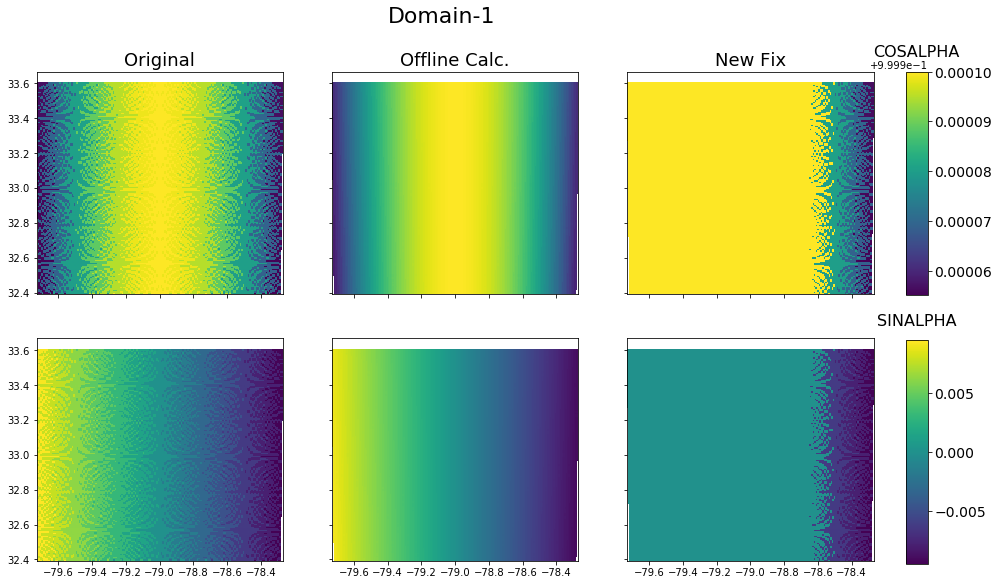

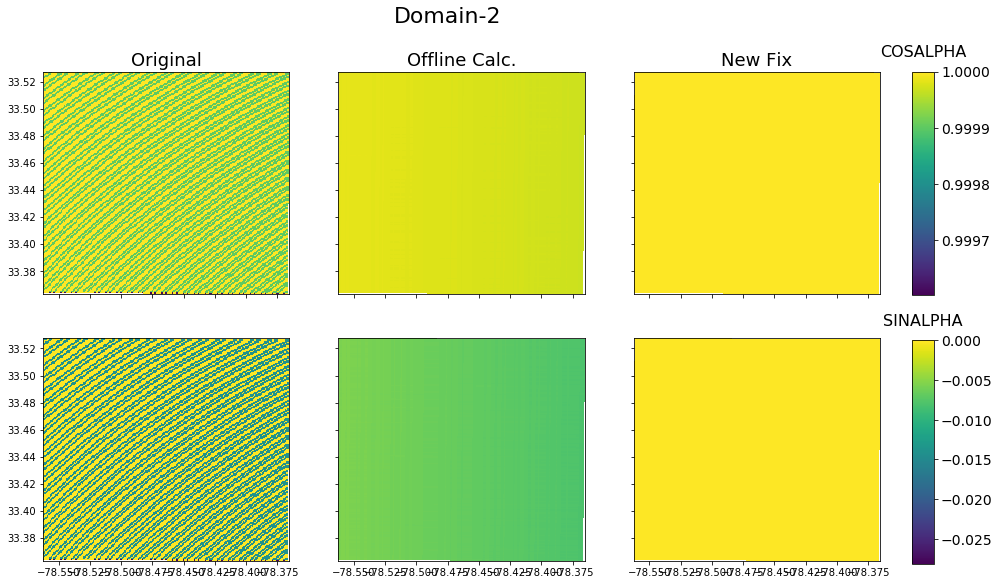

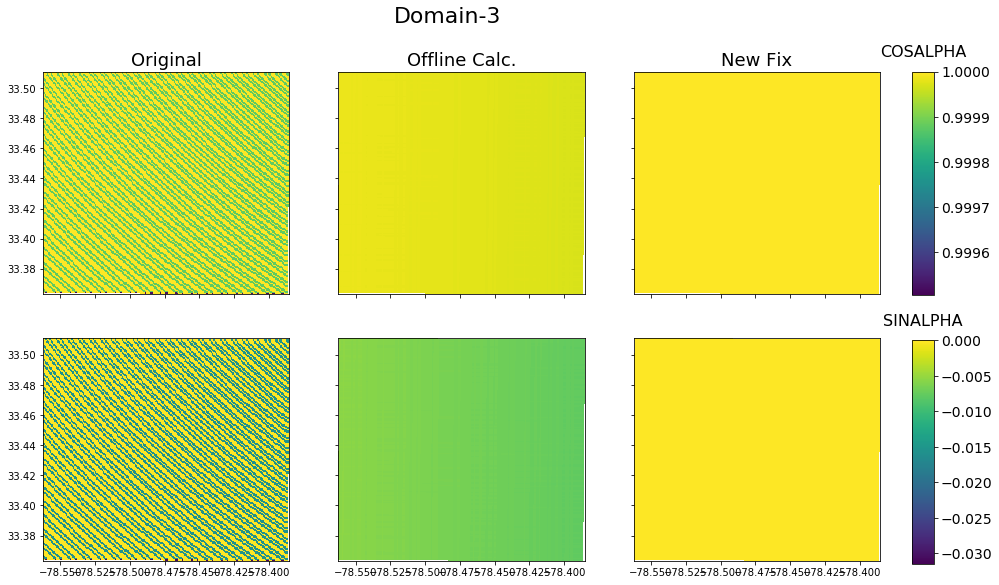

In [32]:
case = cases[0]
for dd,dom in enumerate(doms):

    base_in_fname = '{}{}/geo_em.d0{}.nc'.format(test_dir,base_case,dom)
    new_in_fname = base_in_fname.replace(base_case,case) + '_new'
    base_in = xr.open_dataset(base_in_fname)
    fix_in = xr.open_dataset(base_in_fname.replace(base_case,'fix_geo_em')).squeeze()
    wrf_lat = base_in.XLAT_M.squeeze().data
    wrf_lon = base_in.XLONG_M.squeeze().data

    nx,ny = np.shape(wrf_lon)
    xlon_int = np.zeros(np.shape(wrf_lon),dtype=dt)
    xlat_int = np.zeros(np.shape(wrf_lat),dtype=dt)
    for jj in range(0,ny):
        xlon_int[:,jj] = np.linspace(wrf_lon[0,jj],wrf_lon[-1,jj],nx, dtype=dt)
    for ii in range(0,nx):
        xlat_int[ii,:] = np.linspace(wrf_lat[ii,0],wrf_lat[ii,-1],nx, dtype=dt)

    cosa_dict = {}
    sina_dict = {}
    fig,ax = plt.subplots(ncols=3,nrows=2,figsize=(15,9),sharex=True,sharey=True)
    for uu,use_wrf_latlon in enumerate([True,False]):
        if use_wrf_latlon:
            xlon_arr = wrf_lon
            xlat_arr = wrf_lat
        else:
            xlon_arr = xlon_int
            xlat_arr = xlat_int        

        transpose_vars = True
        if transpose_vars:
            xlon_arr = xlon_arr.T
            xlat_arr = xlat_arr.T

        sina,cosa,atanAf,atanBf,atanA1,atanA2,dlon_a = get_rotang(xlon_arr,xlat_arr)

        if transpose_vars:
            cosa = cosa.T
            sina = sina.T
            xlat_arr = xlat_arr.T
            xlon_arr = xlon_arr.T
            atanAf = atanAf.T
            atanBf = atanBf.T
            atanA1 = atanA1.T
            atanA2 = atanA2.T


        if uu == 0:
            cmin = np.nanmin(cosa)
            cmax = np.nanmax(cosa)
            smin = np.nanmin(sina)
            smax = np.nanmax(sina)
        ax[0,uu].pcolormesh(xlon_arr,xlat_arr,cosa,vmin=cmin,vmax=cmax)
        ax[1,uu].pcolormesh(xlon_arr,xlat_arr,sina,vmin=smin,vmax=smax)

        cosa_dict[uu] = cosa.copy()
        sina_dict[uu] = cosa.copy()

        if not use_wrf_latlon:
            base_in.COSALPHA.data[0,:,:] = cosa
            base_in.SINALPHA.data[0,:,:] = sina

            
    #dplt1 = ax[0,2].pcolormesh(xlon_arr,xlat_arr,(cosa_dict[1] - cosa_dict[0]))
    #dplt2 = ax[1,2].pcolormesh(xlon_arr,xlat_arr,(sina_dict[1] - sina_dict[0]))
    #plt.colorbar(dplt1,ax=ax[0,2])
    #plt.colorbar(dplt2,ax=ax[1,2])
    dplt1 = ax[0,2].pcolormesh(xlon_arr,xlat_arr,fix_in.COSALPHA,vmin=cmin,vmax=cmax)
    dplt2 = ax[1,2].pcolormesh(xlon_arr,xlat_arr,fix_in.SINALPHA,vmin=smin,vmax=smax)
    
    cax1  = fig.add_axes([0.93,0.535,0.02,0.345])
    cbar1 = plt.colorbar(dplt1,cax=cax1)
    cbar1.ax.tick_params(labelsize=14)
    cbar1.ax.set_title('COSALPHA',size=16,y=1.04)
    
    cax2  = fig.add_axes([0.93,0.12,0.02,0.345])
    cbar2 = plt.colorbar(dplt2,cax=cax2)
    cbar2.ax.tick_params(labelsize=14)
    cbar2.ax.set_title('SINALPHA',size=16,y=1.04)
    
    ax[0,0].set_title('Original',size=18)
    ax[0,1].set_title('Offline Calc.',size=18)
    ax[0,2].set_title('New Fix',size=18)
    plt.suptitle('Domain-{}'.format(dom),size=22)
    plt.show()
    #base_in.to_netcdf(new_in_fname)
    base_in.close()




# FOR TESTING

In [100]:
tower_dat_f = xr.load_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d05testtemp.nc')

In [179]:
wrfout_f = sorted(glob.glob('{}{}/wrfout_d05*'.format(main_directory,case)))[3:]

init_wrf_f = True
for wf in wrfout_f[-6:]:
    wrf = xr.open_dataset(wf).squeeze()
    wrf = wrf[['U']]
    wrf = wrf.expand_dims({'datetime':[pd.to_datetime(wrf.XTIME.data)]})
    wrf = wrf.drop('XTIME')
    if init_wrf_f:
        wrf_f = wrf.copy()
        init_wrf_f = False
    else:
        wrf_f = xr.merge([wrf_f,wrf])

wrf_u = (wrf_f.U[:,:,:,1:] + wrf_f.U[:,:,:,:-1])*0.5

wrf_u = wrf_u.rename({'west_east_stag':'west_east'})

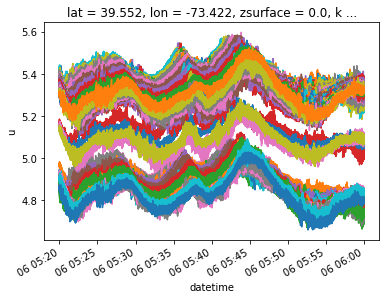

In [55]:
for stn in tower_dat.station:
    twr = tower_dat.sel(station=stn,nz=0)
    twr.u.plot()
plt.show()




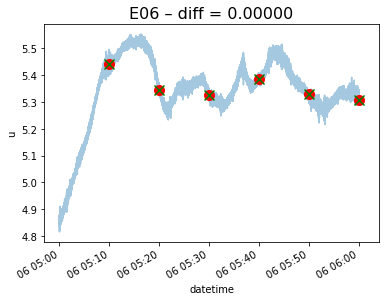

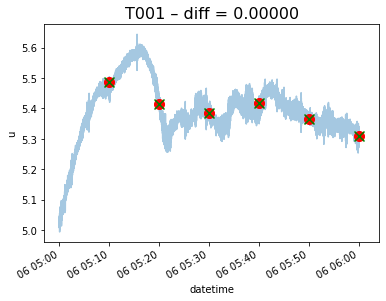

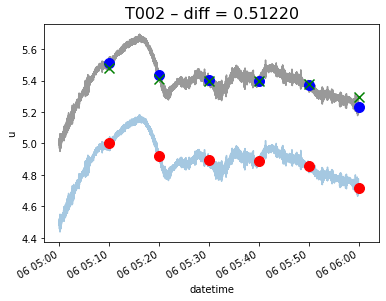

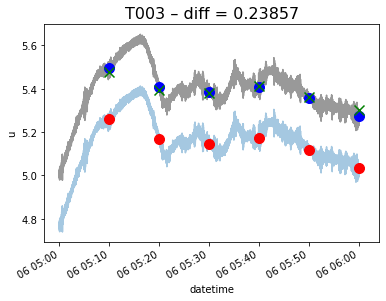

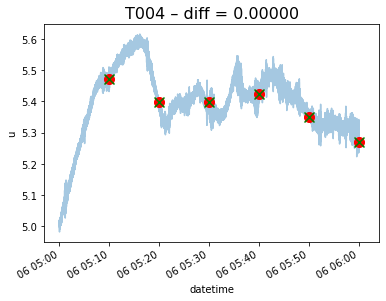

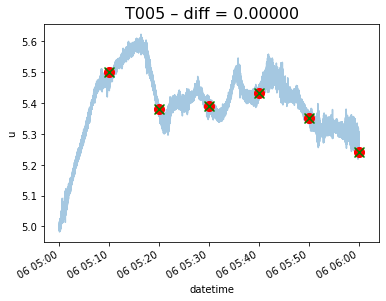

In [219]:
for stn in tower_dat.station:
    twr = tower_dat.sel(station=stn,nz=0)
    c = wrf_u.sel(south_north=twr.j-1,west_east=twr.i-1,bottom_top=0)

    twr.u.plot(alpha=0.4)
    twr_pts = twr.sel(datetime=wrf_f.datetime.data[:])
    diff = c.data - twr_pts.u.data 
    if abs(np.round(np.mean(diff),decimals=5)) > 0:
        
        #shift = np.mean(c.data/twr_pts.u.data)
        shift_twr = twr.u*shift
        shift = np.mean(diff)
        shift_twr = twr.u + shift
        shift_twr.plot(c='k',alpha=0.4)
        shift_pts = shift_twr.sel(datetime=wrf_f.datetime.data[:])

        plt.scatter(pd.to_datetime(shift_pts.datetime.data),
                    shift_pts.data,
                    c='b',marker='o',s=100,zorder=10)
    plt.scatter(pd.to_datetime(twr_pts.datetime.data),
                twr_pts.u.data,
                c='r',marker='o',s=100,zorder=10)
    plt.scatter(wrf_f.datetime.data,
                c,
                c='g',marker='x',s=100,zorder=10)
    plt.title('{0} – diff = {1:6.5f}'.format(str(stn.data),np.mean(diff)),size=16)
    plt.show()




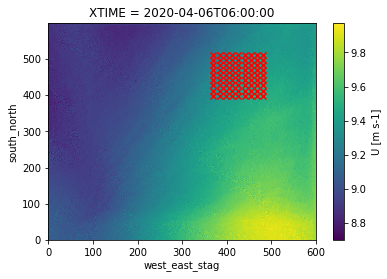

In [76]:
wrf.U.sel(bottom_top=4).plot()
for stn in tower_dat.station:
    twr = tower_dat.sel(station=stn)
    plt.scatter(twr.i,twr.j,c='r',marker='x')
    

<xarray.DataArray 'U' ()>
array(8.467535, dtype=float32)
Coordinates:
    XTIME     datetime64[ns] ...
    XLAT_U    float32 ...
    XLONG_U   float32 ...
    lat       float64 39.55
    lon       float64 -73.42
    zsurface  float64 0.0
    station   <U4 'T081'
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  x-wind component
    units:        m s-1
    stagger:      X

(array([ 2.,  1.,  6.,  7., 11., 14., 13., 12., 10.,  5.]),
 array([8.327754, 8.352076, 8.376397, 8.400719, 8.42504 , 8.449362,
        8.473684, 8.498006, 8.522327, 8.546649, 8.570971], dtype=float32),
 <a list of 10 Patch objects>)

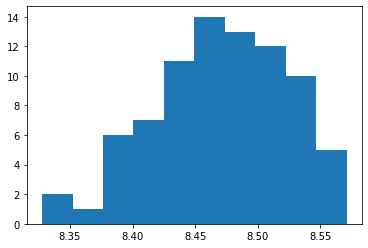

In [91]:
vals = []
for stn in tower_dat.station:
    twr = tower_dat.sel(station=stn)
    c = wrf.sel(south_north=twr.j,west_east_stag=twr.i,bottom_top=3).U.data
    vals += [c]
    
plt.hist(vals)

In [46]:
for j in tower_pert.ny:
    for i in tower_pert.nx:
        #tower_dat.sel(nx=i,ny=j,nz=4).w.plot()
        (((tower_dat.sel(nx=i,ny=j,nz=4).u)**2 + (tower_dat.sel(nx=i,ny=j,nz=4).v)**2)**0.5).plot()
    plt.show()
#        tower_pert.sel(nx=i,ny=j,nz=4).u.plot(c='b')
tower_mean.sel(nz=4).u.plot(c='g')
plt.show()

ValueError: dimensions or multi-index levels ['nx', 'ny'] do not exist

In [ ]:
## Need to take averages over tower_dat and in time for mean
## --- maybe line of best fit instead of averaging? Would help gain more time...
## Then calculate u' v' w'
## Then calculate TKE resolved and add tk

In [197]:
np.mean(twr_pts.u.data - c.data)

-2.5390624980303755e-07

In [7]:
tower_mean = tower_dat.mean(dim=('nx','ny'))

tower_pert = tower_dat[['u','v','w']] - tower_mean[['u','v','w']] 

In [32]:
test = tower_dat.mean(dim='datetime')

In [33]:
test

<xarray.Dataset>
Dimensions:   (nx: 9, ny: 9, nz: 10)
Coordinates:
    i         (ny, nx) int64 370 384 398 412 426 440 ... 412 426 440 454 468 482
    j         (ny, nx) int64 399 399 399 399 399 399 ... 511 511 511 511 511 511
    lat       (ny, nx) float64 39.54 39.54 39.54 39.54 ... 39.55 39.55 39.55
    lon       (ny, nx) float64 -73.44 -73.43 -73.43 ... -73.43 -73.42 -73.42
    zsurface  (ny, nx) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    z         (nz) float64 18.0 38.0 58.0 78.0 98.0 ... 138.0 158.0 178.0 198.0
Dimensions without coordinates: nx, ny, nz
Data variables:
    tk        (nz, ny, nx) float64 0.05486 0.05485 ... 9.619e-05 9.647e-05
    u         (nz, ny, nx) float64 3.387 3.391 3.395 3.399 ... 7.656 7.663 7.67
    v         (nz, ny, nx) float64 6.354 6.352 6.159 6.357 ... 7.518 7.517 7.516
    w         (nz, ny, nx) float64 -0.0008599 -0.0008913 ... -0.01728 -0.01755

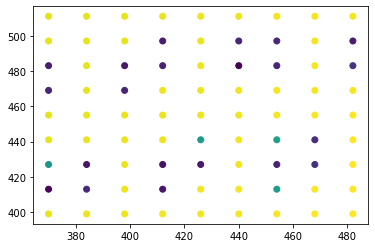

In [38]:
plt.scatter(test.i,test.j,c=test.u.sel(nz=4))

In [15]:
select_vars=['u','v','w','ph','lat','lon','i','j','zsurface','wspd']
native_vars = select_vars.copy()
native_vars.remove('wspd')
native_vars

['u', 'v', 'w', 'ph', 'lat', 'lon', 'i', 'j', 'zsurface']

In [99]:
tower_f

'/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/tower_netCDFs/NYSERDA_MERRA2_DFLT_NOSK_CHRN_MDIS_towers_d05test.nc'

In [ ]:
                print('Saving to file: {}'.format(tower_f))
                tower_dat.to_netcdf(tower_f)
            else:
                get_avg_profile = False
                chunked_list = list()
                chunk_size = 2
                for i in range(0, len(restarts), chunk_size):
                    chunked_list.append(restarts[i:i+chunk_size])

                for cc,chunk in enumerate(chunked_list):
                    chunk_f = tower_f.replace('.nc','_chunk{}.nc'.format(cc))
                    if not path.exists(chunk_f):
                        tower_dat = tsout_seriesReader(fdir=f_dir,
                                                       restarts=chunk,
                                                       simulation_start_time=[sim_start]*len(chunk),
                                                       domain_of_interest=dom_str,
                                                       time_step=time_step,
                                                       structure='unordered',
                                                      )
                        print('Saving to file: {}'.format(chunk_f))
                        tower_dat.to_netcdf(chunk_f)
                    else:
                        tower_dat = xr.open_dataset(chunk_f)

                    grid_stns = []
                    for stn in tower_dat.station.data:
                        if stn[0] == 'T':
                            grid_stns += [str(stn)]

                    avg_twr = averageTslistData(tower_dat.sel(station=grid_stns))
                    del(tower_dat)
                    if cc == 0:
                        avg_twr_f = avg_twr
                    else:
                        avg_twr_f = xr.merge([avg_twr_f,avg_twr])
                if not path.exists(avg_tower_f):
                    print('Saving to file: {}'.format(avg_tower_f))
                    avg_twr_f.to_netcdf(avg_tower_f)
            

        if get_avg_profile:
            if path.exists(avg_tower_f):
                print('Average already exists {}'.format(avg_tower_f))
            else:
                print('Taking average of tslist output')
                grid_stns = []
                for stn in tower_dat.station.data:
                    if stn[0] == 'T':
                        grid_stns += [str(stn)]
                avg_twr = averageTslistData(tower_dat.sel(station=grid_stns))

                print('Saving to file: {}'.format(avg_tower_f))
                avg_twr.to_netcdf(avg_tower_f)
print('Finished.')

In [10]:
test_met = xr.open_dataset('/glade/work/hawbecke/MMC/NYSERDA/met_em/MERRA2/orig/met_em.d05.2020-04-06_06:00:00.nc').squeeze()

'num_st_layers'

<xarray.DataArray 'SOIL_LAYERS' (south_north: 600, west_east: 600)>
[360000 values with dtype=float32]
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    units:        
    description:  
    stagger:      M
    sr_x:         1
    sr_y:         1

0
Times
3


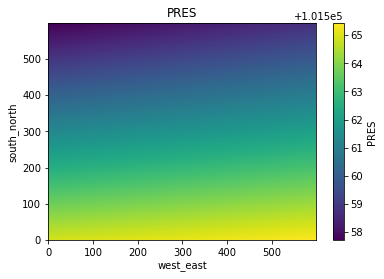

3


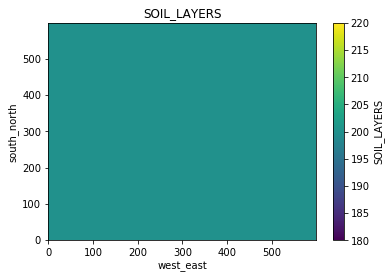

3


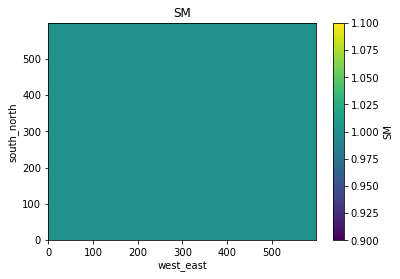

3


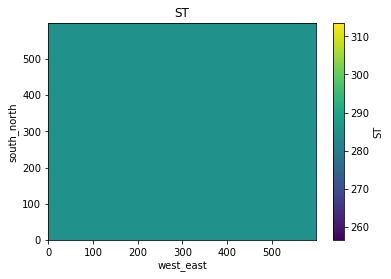

2


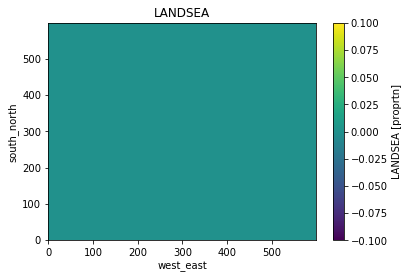

2


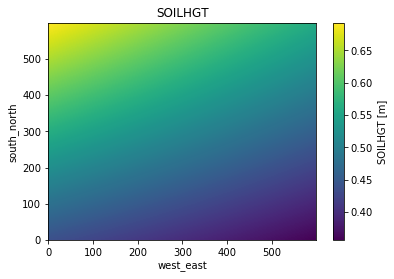

2


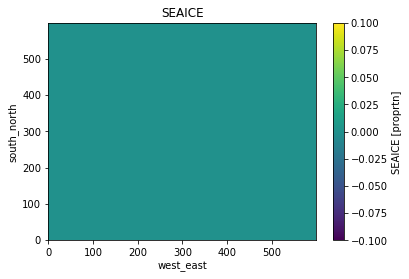

2


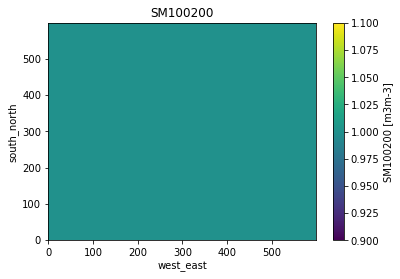

2


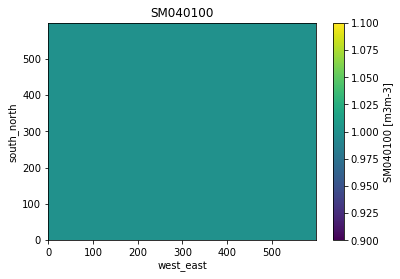

2


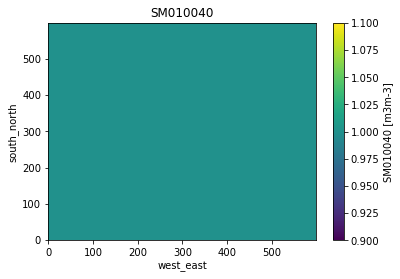

2


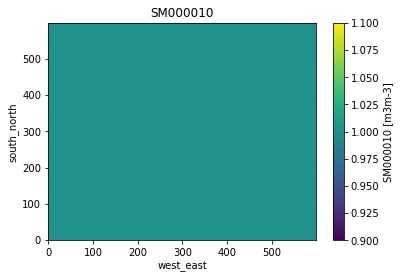

2


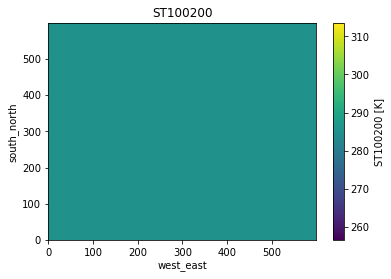

2


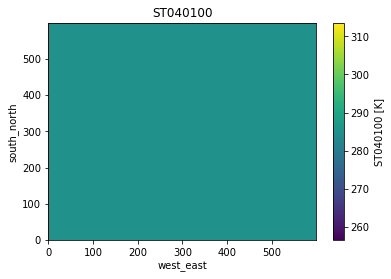

2


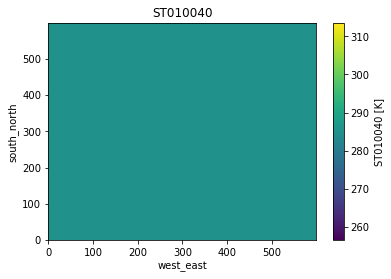

2


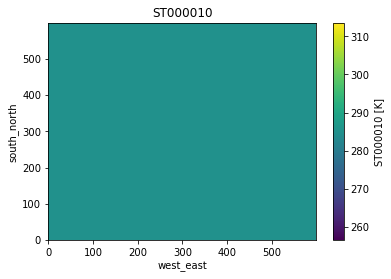

2


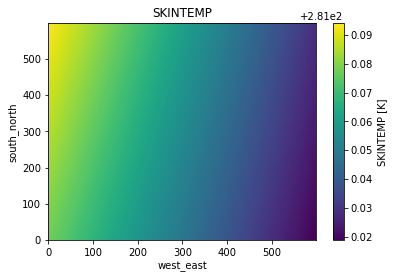

2


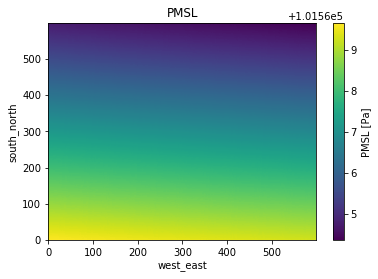

2


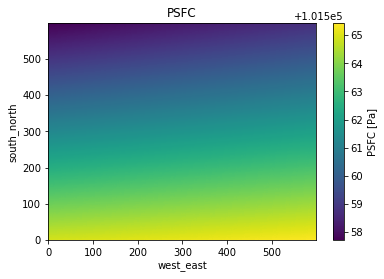

3


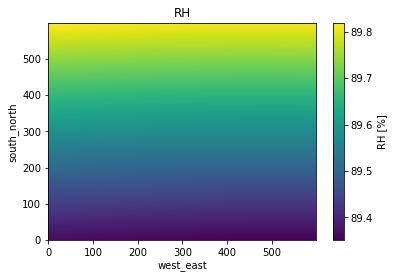

3


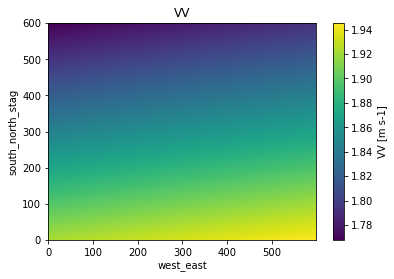

3


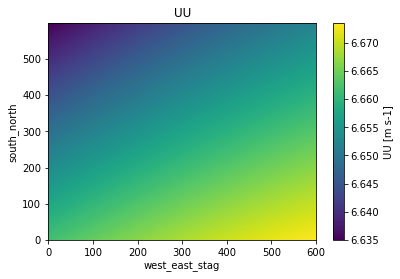

3


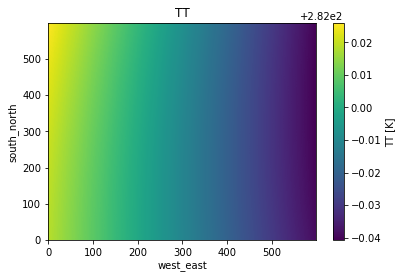

3


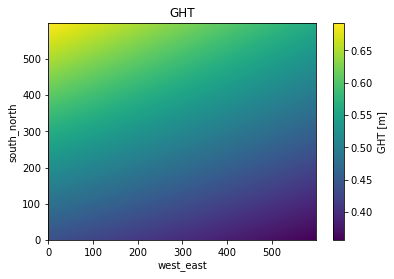

3


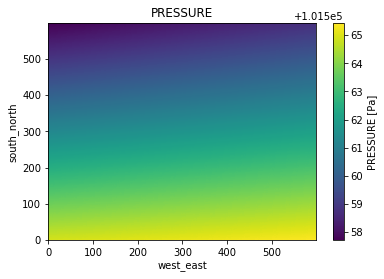

2


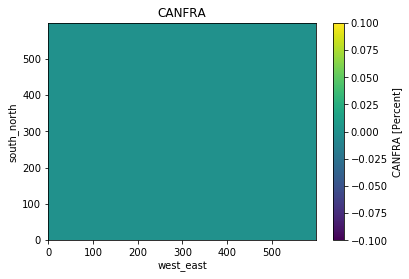

2


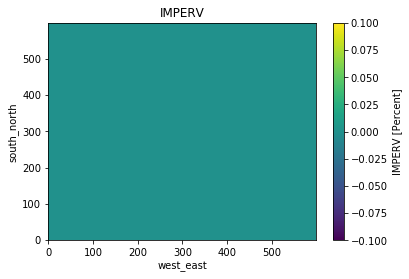

3


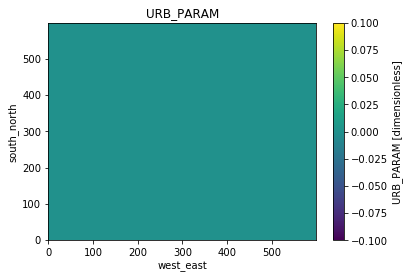

2


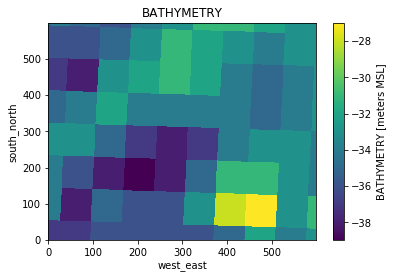

2


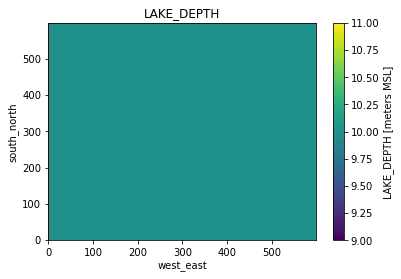

2


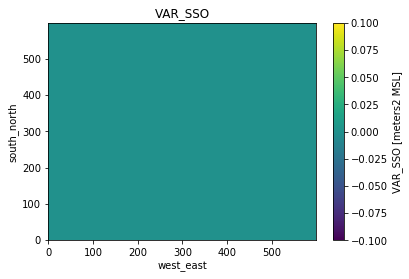

2


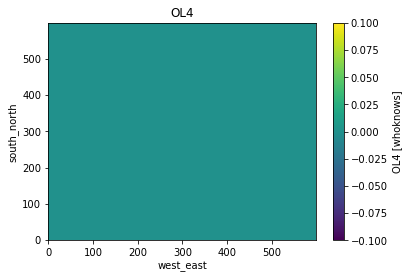

2


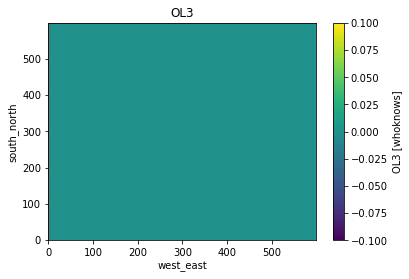

2


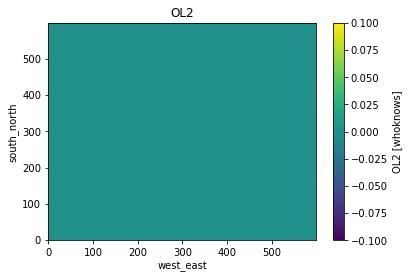

2


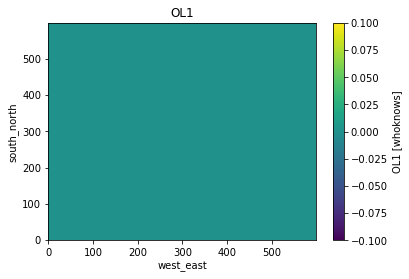

2


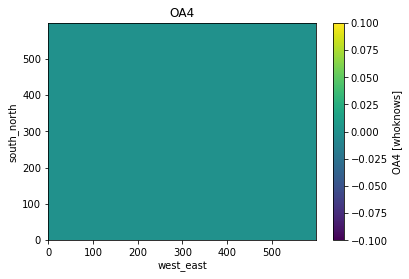

2


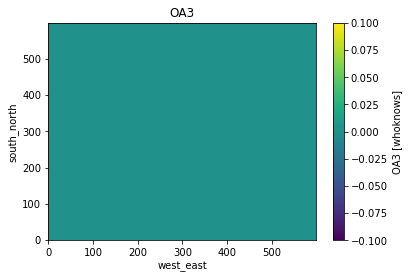

2


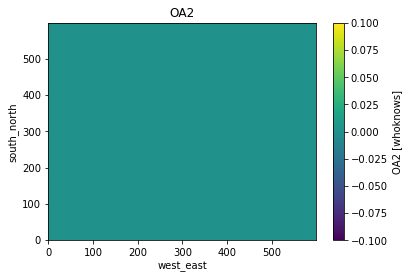

2


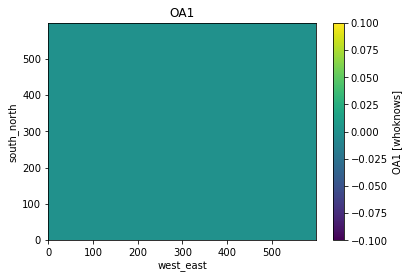

2


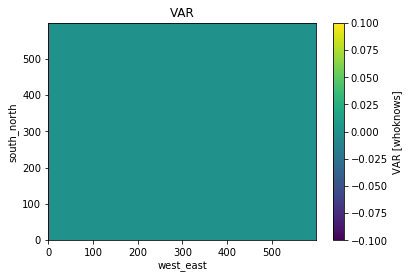

2


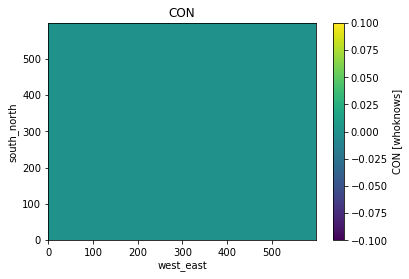

2


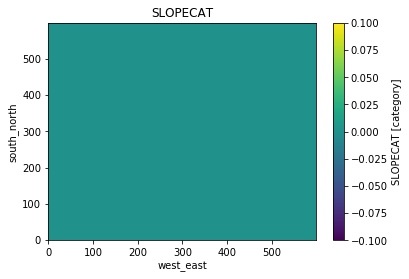

2


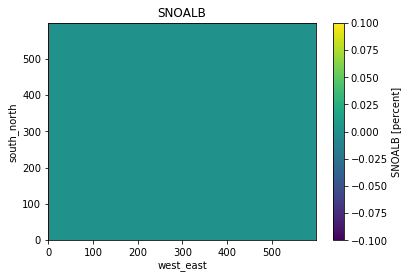

3


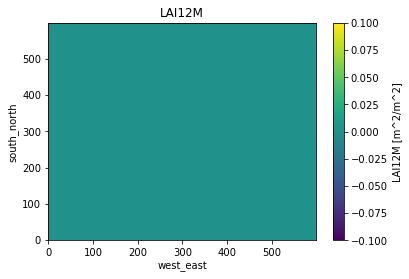

3


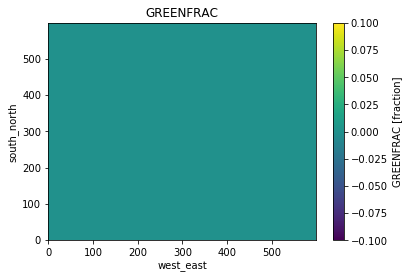

3


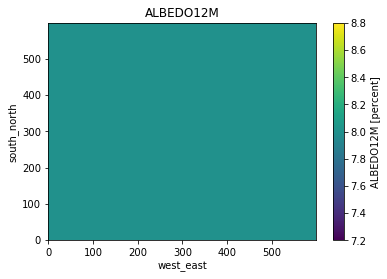

2


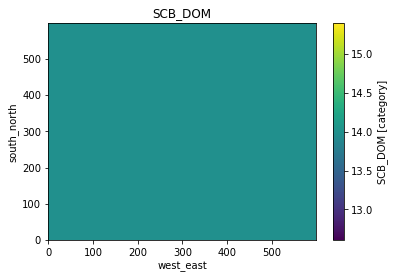

3


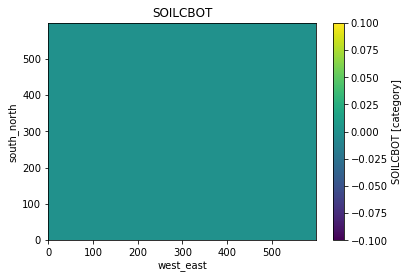

2


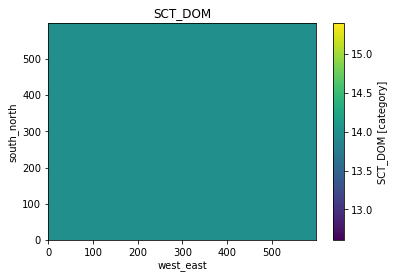

3


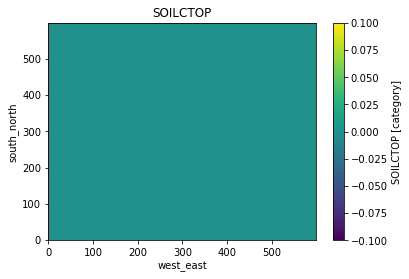

2


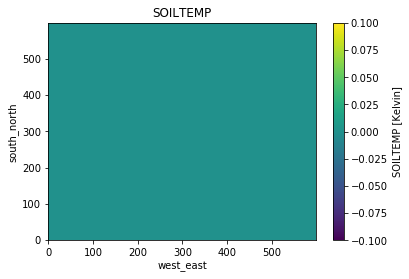

2


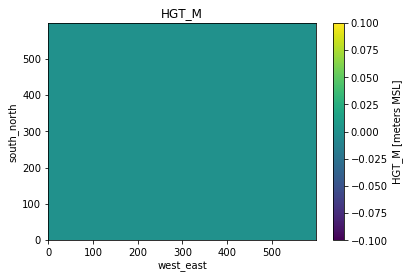

2


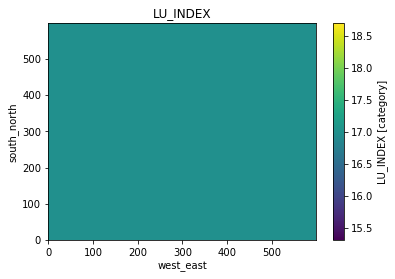

3


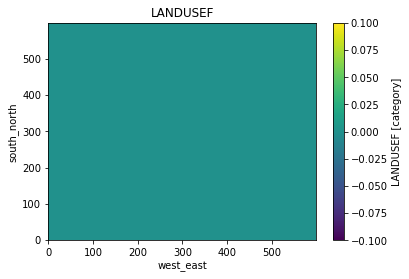

2


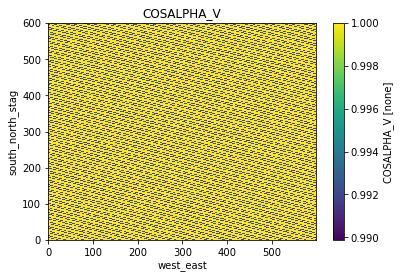

2


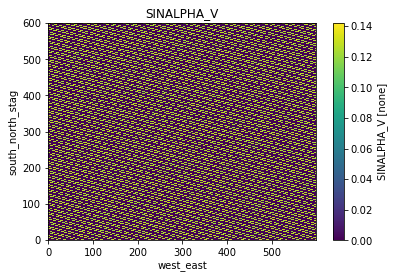

2


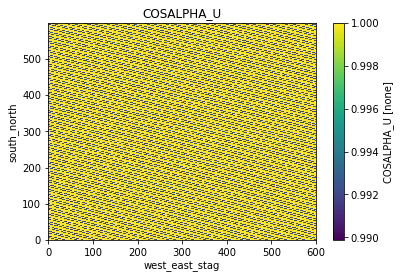

2


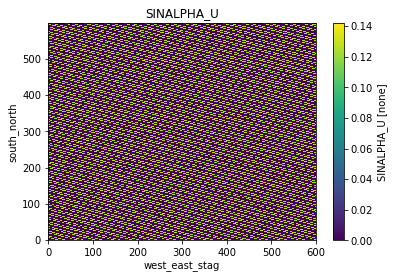

2


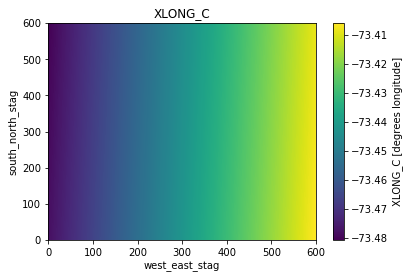

2


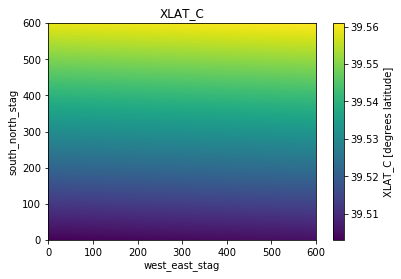

2


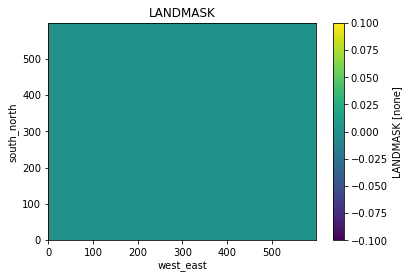

2


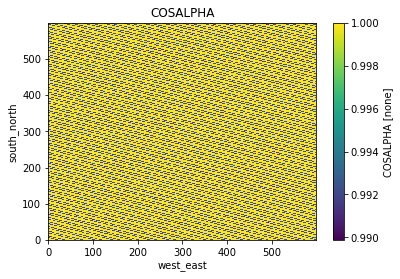

2


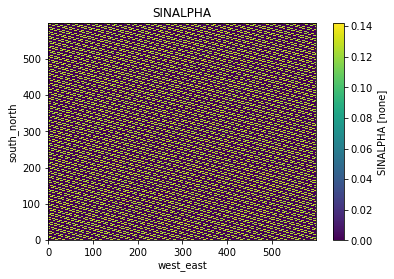

2


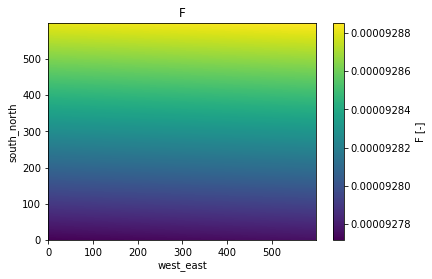

2


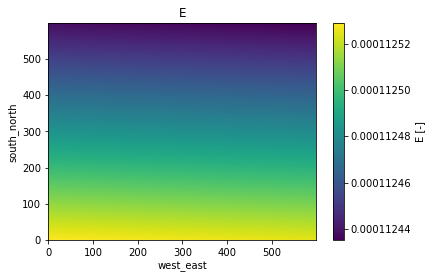

2


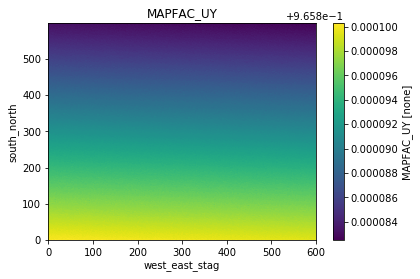

2


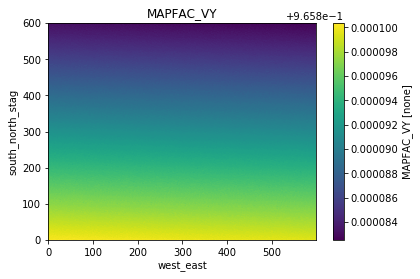

2


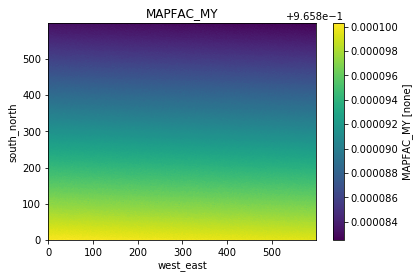

2


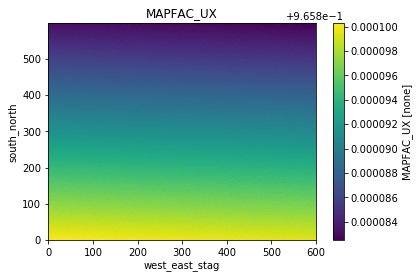

2


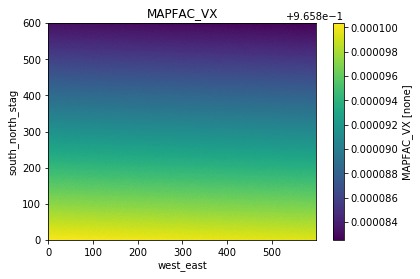

2


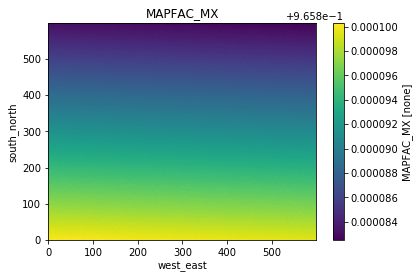

2


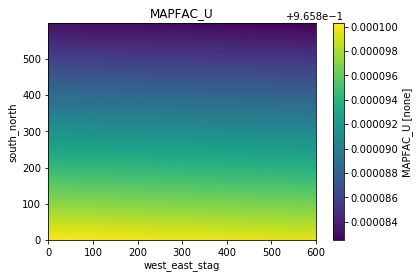

2


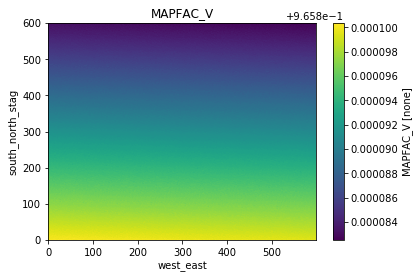

2


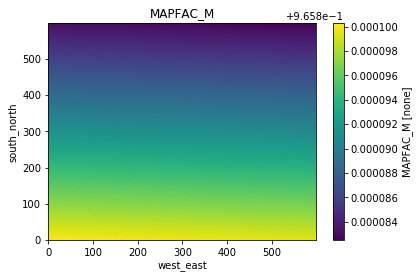

2


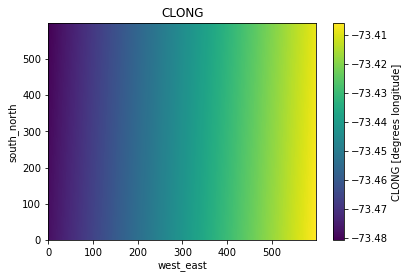

2


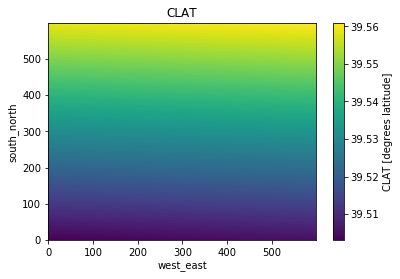

2


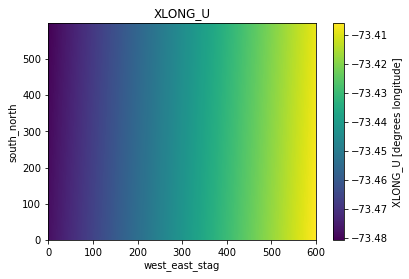

2


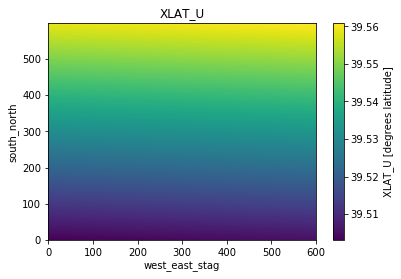

2


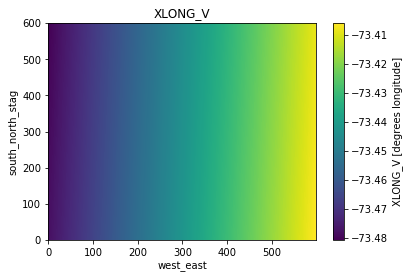

2


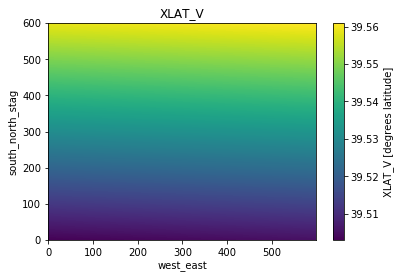

2


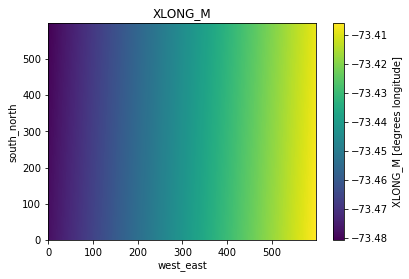

2


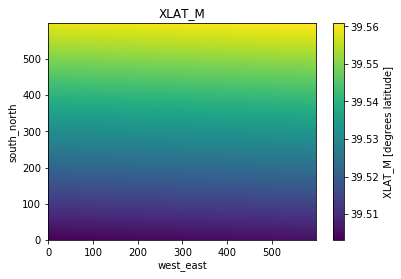

In [23]:
for varn in test_met.data_vars:
    dat = test_met[varn]
    ndims = len(np.shape(dat))
    print(ndims)
    if ndims == 2:
        dat.plot()
        plt.title(str(varn))
        plt.show()
    elif ndims == 3:
        
        dat.isel({dat.dims[0]:0}).plot()
        plt.title(str(varn))
        plt.show()
    else:
        print(varn)


In [31]:
dd = 17
alphabet_str = ''
for letter in ascii_lowercase[:dd+5]:
    alphabet_str += '{} '.format(letter.upper())
print(alphabet_str)

A B C D E F G H I J K L M N O P Q R S T U V 


In [76]:
test = pd.read_csv('~/test.txt',delim_whitespace=True)

In [77]:
hours = np.asarray(test.hours.values,dtype=float)

In [79]:
total = hours.sum()

In [80]:
1.5/0.7

2.142857142857143

In [81]:
premium = total*(1.5/0.7)

In [83]:
print(total,premium)

137460.24000000002 294557.65714285715


In [84]:
premium*4

1178230.6285714286